In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        e*I,
        m*I,
        g*E,
        e*I
    ]

In [3]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [4]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

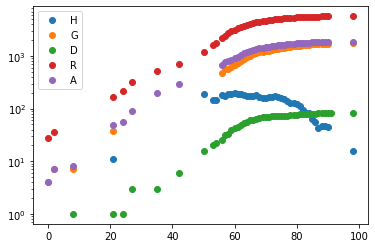

In [5]:
plt.semilogy(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

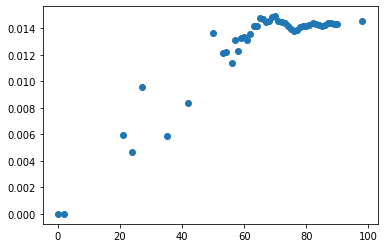

In [6]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [7]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
clip = 15
data_time = time[start:clip]
data_pd = data_pd[start:clip,:]

p0 = [1.5, 1e-6, 0, 1e-6, 1e-6, 0.015]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

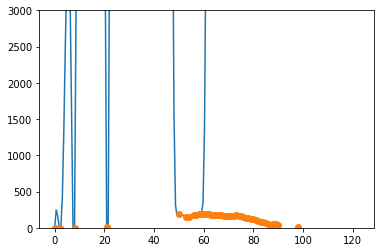

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [ ]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  60  1.5780603e+01 0.00e+00 6.17e-01  -8.6 5.62e+03 -13.5 6.75e-01 4.78e-01f  2
  70  1.5779847e+01 0.00e+00 4.22e-01  -8.6 2.03e+03 -13.7 2.31e-01 1.00e+00f  1
  80  1.5779324e+01 0.00e+00 2.08e-01  -8.6 4.46e+03 -11.3 1.43e-01 2.56e-02f  5
  90  1.5778889e+01 0.00e+00 3.35e-01  -8.6 1.16e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5778336e+01 0.00e+00 2.30e-01  -8.6 8.37e+02    -  1.00e+00 7.26e-01f  1
 110  1.5777891e+01 0.00e+00 2.39e-01  -8.6 1.19e+03    -  1.00e+00 1.00e+00f  1
 120  1.5777570e+01 0.00e+00 2.47e-01  -8.6 1.36e+03    -  8.63e-01 1.00e+00f  1
 130  1.5777339e+01 0.00e+00 2.12e-01  -8.6 3.15e+03    -  5.41e-01 6.49e-01h  1
 140  1.5777121e+01 0.00e+00 1.40e-01  -8.6 7.41e+02    -  5.06e-04 8.58e-02f  1
 150  1.5776977e+01 0.00e+00 1.57e-01  -8.6 7.04e+02    -  9.04e-01 9.98e-01h  1
 160  1.5776846e+01 0.00e+00 5.64e-02  -8.6 4.94e+02    -  4.44e-01 1.00e+00f  1
 170  1.5776749e+01 0.00e+00

  40  1.5835973e+01 0.00e+00 3.74e-01  -5.7 4.13e+03 -11.7 1.00e+00 1.00e+00f  1
  50  1.5822423e+01 0.00e+00 6.28e-01  -5.7 7.21e+02 -11.9 1.00e+00 1.00e+00f  1
  60  1.5816927e+01 0.00e+00 1.10e-01  -5.7 1.55e+02 -11.3 1.00e+00 1.00e+00f  1
  70  1.5814325e+01 0.00e+00 1.96e-01  -5.7 4.19e+04    -  5.44e-01 2.12e-01f  2
  80  1.5813107e+01 0.00e+00 8.64e-01  -5.7 7.79e+03    -  1.00e+00 2.50e-01f  3
  90  1.5812212e+01 0.00e+00 5.31e-01  -5.7 1.31e+04    -  1.00e+00 1.57e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5811509e+01 0.00e+00 1.32e-01  -5.7 5.23e+02 -12.9 1.00e+00 1.00e+00f  1
 110  1.5810891e+01 0.00e+00 2.97e-01  -5.7 8.33e+02 -14.9 1.00e+00 1.00e+00h  1
 120  1.5810371e+01 0.00e+00 2.13e-01  -5.7 1.19e+04    -  1.00e+00 1.00e+00f  1
 130  1.5809967e+01 0.00e+00 1.93e-01  -5.7 8.49e+02 -14.8 1.00e+00 1.00e+00h  1
 140  1.5809685e+01 0.00e+00 5.74e-03  -5.7 1.75e+02 -12.7 1.00e+00 1.00e+00f  1
 150  1.5809462e+01 0.00e+00

  60  1.5870012e+01 0.00e+00 1.86e+00  -8.6 3.72e+03 -13.0 1.00e+00 1.00e+00f  1
  70  1.5867575e+01 0.00e+00 7.50e-01  -8.6 1.51e+04 -14.2 2.43e-04 1.00e+00f  1
  80  1.5866121e+01 0.00e+00 9.23e-01  -8.6 8.64e+02 -12.7 1.00e+00 5.98e-01f  1
  90  1.5865155e+01 0.00e+00 7.51e-01  -8.6 1.49e+03 -12.9 1.00e+00 8.69e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5864271e+01 0.00e+00 1.06e+00  -8.6 2.87e+03    -  1.00e+00 5.00e-01f  2
 110  1.5863525e+01 0.00e+00 4.48e-01  -8.6 1.45e+03    -  1.00e+00 1.00e+00f  1
 120  1.5863054e+01 0.00e+00 9.95e-01  -8.6 1.28e+03    -  1.00e+00 1.00e+00f  1
 130  1.5862563e+01 0.00e+00 4.39e-01  -8.6 9.24e+02    -  1.00e+00 1.00e+00f  1
 140  1.5862174e+01 0.00e+00 1.65e-01  -8.6 3.78e+02    -  1.00e+00 1.00e+00f  1
 150  1.5861868e+01 0.00e+00 3.21e-01  -8.6 9.53e+02 -12.2 3.99e-01 4.58e-01f  1
 160  1.5861594e+01 0.00e+00 3.59e-01  -8.6 6.40e+02    -  2.13e-01 1.00e+00f  1
 170  1.5861369e+01 0.00e+00

  40  1.5994325e+01 0.00e+00 3.50e+00  -3.8 9.25e+02 -10.8 1.00e+00 1.00e+00f  1
  50  1.5994814e+01 0.00e+00 1.86e+00  -3.8 7.50e+03    -  1.00e+00 5.00e-01f  2
  60  1.6002380e+01 0.00e+00 3.02e-01  -3.8 1.03e+03    -  1.00e+00 1.00e+00f  1
  70  1.6008815e+01 0.00e+00 3.70e-01  -3.8 4.75e+02    -  1.00e+00 1.00e+00h  1
  80  1.6016218e+01 0.00e+00 3.08e-01  -3.8 2.46e+03    -  1.00e+00 1.00e+00f  1
  90  1.6023327e+01 0.00e+00 3.31e+00  -3.8 2.56e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6027297e+01 0.00e+00 2.46e+00  -3.8 6.18e+03    -  1.00e+00 2.50e-01f  3
 110  1.6029460e+01 0.00e+00 1.64e+00  -3.8 4.44e+03    -  1.00e+00 5.00e-01f  2
 120  1.5996461e+01 0.00e+00 6.14e-02  -5.7 1.17e+03 -12.9 1.00e+00 1.00e+00f  1
 130  1.5995632e+01 0.00e+00 6.04e-01  -5.7 1.08e+04 -15.0 1.00e+00 5.00e-01f  2
 140  1.5994419e+01 0.00e+00 2.01e+00  -5.7 2.14e+03 -13.4 1.00e+00 1.00e+00f  1
 150  1.5987994e+01 0.00e+00

  40  1.6147818e+01 0.00e+00 2.49e+00  -3.8 3.08e+03 -12.2 1.00e+00 1.00e+00f  1
  50  1.6150238e+01 0.00e+00 6.30e+00  -3.8 7.28e+03    -  8.05e-01 2.50e-01f  3
  60  1.6154617e+01 0.00e+00 7.92e-01  -3.8 7.96e+02    -  1.00e+00 1.00e+00f  1
  70  1.6158601e+01 0.00e+00 2.99e-05  -3.8 4.01e+00    -  1.00e+00 1.00e+00h  1
  80  1.6125218e+01 0.00e+00 2.52e+00  -5.7 4.83e+03 -12.6 1.00e+00 2.50e-01f  3
  90  1.6120553e+01 0.00e+00 2.62e-02  -5.7 8.18e+01 -10.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6118269e+01 0.00e+00 4.05e-01  -5.7 5.47e+02 -11.7 1.00e+00 1.00e+00f  1
 110  1.6116004e+01 0.00e+00 1.84e+00  -5.7 9.58e+03 -14.1 8.30e-01 1.00e+00f  1
 120  1.6114327e+01 0.00e+00 3.97e-01  -5.7 4.65e+02 -12.9 1.00e+00 1.00e+00f  1
 130  1.6113189e+01 0.00e+00 2.41e-01  -5.7 3.39e+02 -13.1 1.00e+00 1.00e+00f  1
 140  1.6112173e+01 0.00e+00 1.10e+00  -5.7 1.54e+03 -13.7 1.00e+00 5.00e-01f  2
 150  1.6111285e+01 0.00e+00

 320  1.6217987e+01 0.00e+00 1.20e-03  -8.6 1.92e+00  -9.7 1.00e+00 1.00e+00h  1
 330  1.6217986e+01 0.00e+00 5.03e-03  -8.6 9.33e+02 -14.5 1.00e+00 1.00e+00h  1
 340  1.6217979e+01 0.00e+00 1.71e-07  -8.6 4.16e+00 -12.0 1.00e+00 1.00e+00h  1
 350  1.6218766e+01 0.00e+00 2.07e+00  -8.6 3.10e+02 -11.4 1.00e+00 1.01e-14h 43
 360  1.6217979e+01 0.00e+00 3.22e-02  -8.6 5.78e+02    -  5.78e-01 1.00e+00f  1

Number of Iterations....: 369

                                   (scaled)                 (unscaled)
Objective...............:   1.6217975572008275e+01    1.6217975572008275e+01
Dual infeasibility......:   3.4376587906271812e-11    3.4376587906271812e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035613598634e-09    2.5059035613598634e-09
Overall NLP error.......:   2.5059035613598634e-09    2.5059035613598634e-09


Number of objective function evaluations             = 790
Number of objective gradient evaluations      

  20  1.7755669e+01 0.00e+00 1.29e+01  -3.8 8.24e+02  -7.8 9.44e-01 7.40e-01f  1
  30  1.6591342e+01 0.00e+00 5.99e+00  -3.8 9.94e+03    -  3.72e-01 1.25e-01f  4
  40  1.6591389e+01 0.00e+00 7.49e+00  -3.8 1.74e+04    -  6.02e-01 2.50e-01f  3
  50  1.6590982e+01 0.00e+00 2.81e-01  -3.8 1.66e+02  -9.7 1.00e+00 1.00e+00f  1
  60  1.6592980e+01 0.00e+00 2.16e+00  -3.8 8.39e+02 -12.0 1.00e+00 1.00e+00f  1
  70  1.6597566e+01 0.00e+00 3.87e+00  -3.8 4.06e+03    -  1.00e+00 2.50e-01f  3
  80  1.6602757e+01 0.00e+00 3.53e-01  -3.8 3.34e+02    -  1.00e+00 1.00e+00f  1
  90  1.6576969e+01 0.00e+00 8.91e+00  -5.7 1.12e+03 -11.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6571165e+01 0.00e+00 8.54e-03  -5.7 3.92e+01  -9.7 1.00e+00 1.00e+00f  1
 110  1.6567175e+01 0.00e+00 3.88e-01  -5.7 6.79e+02 -12.6 1.00e+00 1.00e+00f  1
 120  1.6564522e+01 0.00e+00 5.18e+00  -5.7 1.49e+04    -  8.44e-01 1.20e-01f  3
 130  1.6562004e+01 0.00e+00

 300  1.6785547e+01 0.00e+00 1.09e+00  -5.7 4.42e+02 -12.3 1.00e+00 1.00e+00f  1
 310  1.6783393e+01 0.00e+00 5.12e-01  -5.7 3.32e+02 -12.6 1.00e+00 1.00e+00f  1
 320  1.6782057e+01 0.00e+00 1.51e-02  -5.7 4.34e+01  -9.2 1.00e+00 1.00e+00h  1
 330  1.6780983e+01 0.00e+00 3.28e+00  -5.7 2.70e+03 -13.0 1.00e+00 1.00e+00f  1
 340  1.6780106e+01 0.00e+00 1.35e+00  -5.7 1.09e+03 -12.3 1.00e+00 5.00e-01f  2
 350  1.6779319e+01 0.00e+00 4.56e-01  -5.7 3.03e+02 -10.7 1.00e+00 1.00e+00f  1
 360  1.6778495e+01 0.00e+00 2.72e+00  -5.7 1.15e+05    -  8.14e-02 1.76e-02f  2
 370  1.6778214e+01 0.00e+00 2.73e-01  -5.7 9.97e+03    -  1.00e+00 5.00e-01f  2
 380  1.6778253e+01 0.00e+00 3.17e-04  -5.7 2.97e+02    -  1.00e+00 1.00e+00h  1
 390  1.6778049e+01 0.00e+00 4.30e-03  -8.6 3.64e+01 -10.4 1.00e+00 2.82e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.6778021e+01 0.00e+00 7.19e-03  -8.6 4.14e+02 -13.4 1.00e+00 1.00e+00h  1
 410  1.6777980e+01 0.00e+00

  30  1.8326211e+01 0.00e+00 1.17e+02  -2.5 1.53e+05    -  9.29e-02 3.92e-02f  3
  40  1.8365733e+01 0.00e+00 1.26e+00  -2.5 2.48e+02  -8.6 1.00e+00 1.00e+00f  1
  50  1.8417437e+01 0.00e+00 7.74e+01  -2.5 6.81e+03    -  1.00e+00 2.50e-01f  3
  60  1.8408509e+01 0.00e+00 5.71e+01  -2.5 1.81e+04    -  9.52e-01 1.00e-01f  4
  70  1.8427502e+01 0.00e+00 2.62e+01  -2.5 4.88e+03    -  1.00e+00 5.00e-01f  2
  80  1.7742353e+01 0.00e+00 1.43e+01  -3.8 2.91e+03 -11.8 1.00e+00 8.87e-02f  1
  90  1.7698441e+01 0.00e+00 1.46e-01  -5.7 6.03e+02 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7694767e+01 0.00e+00 2.89e+00  -5.7 2.56e+03 -13.1 1.00e+00 5.00e-01f  2
 110  1.7690281e+01 0.00e+00 5.28e+00  -5.7 3.92e+03 -12.4 1.00e+00 2.50e-01f  3
 120  1.7678739e+01 0.00e+00 1.59e+00  -5.7 4.96e+02 -11.8 1.00e+00 1.00e+00f  1
 130  1.7646277e+01 0.00e+00 9.74e+00  -5.7 3.37e+03 -11.6 1.31e-01 5.00e-01f  2
 140  1.7603686e+01 0.00e+00

 230  1.7966602e+01 0.00e+00 9.12e+00  -5.7 9.25e+02 -11.6 1.00e+00 1.00e+00f  1
 240  1.7960100e+01 0.00e+00 8.12e-01  -5.7 2.05e+02 -11.8 1.00e+00 1.00e+00f  1
 250  1.7955405e+01 0.00e+00 3.91e+00  -5.7 6.27e+02 -12.1 1.00e+00 1.00e+00f  1
 260  1.7952530e+01 0.00e+00 3.39e+00  -5.7 1.09e+03 -11.4 1.00e+00 5.00e-01f  2
 270  1.7950795e+01 0.00e+00 6.61e-02  -5.7 3.17e+01  -8.9 1.00e+00 1.00e+00h  1
 280  1.7948459e+01 0.00e+00 1.82e-01  -5.7 5.88e+02 -11.9 1.00e+00 1.00e+00f  1
 290  1.7947117e+01 0.00e+00 1.58e-01  -5.7 9.36e+01  -9.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.7944712e+01 0.00e+00 3.35e-03  -5.7 4.49e+00  -7.9 1.00e+00 1.00e+00h  1
 310  1.7943431e+01 0.00e+00 2.44e+01  -5.7 1.43e+04    -  9.73e-01 2.92e-01f  1
 320  1.7940774e+01 0.00e+00 1.18e-02  -5.7 4.88e+01 -10.6 1.00e+00 1.00e+00h  1
 330  1.7938770e+01 0.00e+00 5.85e-02  -5.7 1.11e+01  -8.9 1.00e+00 1.00e+00f  1
 340  1.7938263e+01 0.00e+00

  10  3.3221804e+01 0.00e+00 2.85e+02  -1.0 2.79e+03    -  6.73e-01 5.00e-01f  2
  20  2.1951035e+01 0.00e+00 9.30e+00  -2.5 7.50e+02  -7.8 8.38e-02 1.00e+00f  1
  30  2.0228067e+01 0.00e+00 2.19e-01  -2.5 2.86e+02  -8.5 1.00e+00 1.00e+00f  1
  40  2.0148435e+01 0.00e+00 8.58e+00  -2.5 8.59e+02  -9.7 1.00e+00 1.00e+00f  1
  50  2.0141238e+01 0.00e+00 6.76e+01  -2.5 2.16e+03    -  1.00e+00 1.00e+00f  1
  60  2.0127903e+01 0.00e+00 3.87e+01  -3.8 5.16e+04    -  2.91e-01 9.37e-02f  2
  70  1.9521233e+01 0.00e+00 1.99e+01  -3.8 2.85e+04    -  9.51e-01 6.48e-02f  4
  80  1.9491029e+01 0.00e+00 1.10e+01  -3.8 6.66e+03    -  1.00e+00 2.50e-01f  3
  90  1.9475025e+01 0.00e+00 1.56e+00  -3.8 4.33e+02 -12.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9466511e+01 0.00e+00 2.88e+00  -3.8 5.15e+02    -  1.00e+00 1.00e+00f  1
 110  1.9461457e+01 0.00e+00 2.02e-01  -3.8 1.32e+02    -  1.00e+00 1.00e+00f  1
 120  1.9444152e+01 0.00e+00

  20  3.6956632e+01 0.00e+00 3.88e+00  -1.7 6.73e+01  -5.4 1.00e+00 1.00e+00f  1
  30  2.2460247e+01 0.00e+00 5.63e+01  -2.5 2.94e+03 -10.2 1.00e+00 1.00e+00f  1
  40  2.2240236e+01 0.00e+00 4.80e+01  -2.5 4.79e+03 -10.8 1.00e+00 5.00e-01f  2
  50  2.2250297e+01 0.00e+00 3.57e+00  -2.5 4.45e+02 -10.5 1.00e+00 1.00e+00f  1
  60  2.2282405e+01 0.00e+00 1.20e-01  -2.5 6.19e+01    -  1.00e+00 1.00e+00h  1
  70  2.1733414e+01 0.00e+00 5.91e+00  -3.8 1.17e+03 -11.1 1.00e+00 5.00e-01f  2
  80  2.1705882e+01 0.00e+00 9.18e+00  -3.8 7.40e+02 -10.9 1.00e+00 1.00e+00f  1
  90  2.1695481e+01 0.00e+00 3.36e+00  -3.8 3.83e+02 -12.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1687691e+01 0.00e+00 3.97e+00  -3.8 1.35e+03    -  1.00e+00 1.00e+00f  1
 110  2.1681571e+01 0.00e+00 4.44e+00  -3.8 5.71e+02    -  1.00e+00 1.00e+00f  1
 120  2.1678129e+01 0.00e+00 1.69e+00  -3.8 6.09e+02    -  1.00e+00 5.00e-01h  2
 130  2.1676345e+01 0.00e+00

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5213212e+01 0.00e+00 1.92e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  5.6324090e+01 0.00e+00 7.36e+02  -1.0 1.81e+03    -  6.62e-01 1.00e+00f  1
  20  5.3541831e+01 0.00e+00 2.57e+01  -1.0 2.62e+02  -6.4 1.00e+00 1.00e+00f  1
  30  5.7000051e+01 0.00e+00 1.51e+02  -1.0 2.41e+03  -8.4 1.00e+00 1.00e+00f  1
  40  5.6520803e+0

  60  3.3960150e+01 0.00e+00 5.06e+01  -1.7 1.90e+04    -  6.11e-01 5.00e-01f  2
  70  3.4032811e+01 0.00e+00 4.75e-01  -1.7 2.87e+02    -  1.00e+00 1.00e+00f  1
  80  2.8699567e+01 0.00e+00 9.20e+00  -3.8 1.55e+03 -11.3 1.00e+00 1.00e+00f  1
  90  2.8652861e+01 0.00e+00 4.44e+00  -3.8 1.07e+03 -11.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8605520e+01 0.00e+00 1.98e+01  -3.8 5.98e+03 -11.7 1.00e+00 1.25e-01f  4
 110  2.8497016e+01 0.00e+00 3.84e+00  -3.8 3.17e+02 -10.1 1.00e+00 1.00e+00f  1
 120  2.7980552e+01 0.00e+00 1.22e+02  -3.8 3.94e+03 -10.3 1.00e+00 1.00e+00f  1
 130  2.7557198e+01 0.00e+00 4.38e-01  -3.8 2.41e+02  -9.2 1.00e+00 1.00e+00f  1
 140  2.7389899e+01 0.00e+00 3.68e+00  -3.8 2.87e+02  -9.4 1.00e+00 1.00e+00f  1
 150  2.7280048e+01 0.00e+00 1.38e+01  -3.8 9.48e+03    -  1.00e+00 1.25e-01f  4
 160  2.7192174e+01 0.00e+00 2.90e+01  -3.8 6.86e+03    -  1.00e+00 1.69e-01f  3
 170  2.7142387e+01 0.00e+00

 170  2.9874658e+01 0.00e+00 2.28e+00  -3.8 3.77e+02 -10.3 1.00e+00 1.00e+00f  1
 180  2.9819520e+01 0.00e+00 2.37e+01  -3.8 8.15e+02 -10.9 1.00e+00 1.00e+00f  1
 190  2.9784873e+01 0.00e+00 3.59e+01  -3.8 1.35e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.9760783e+01 0.00e+00 1.84e+01  -3.8 1.26e+04    -  4.88e-01 2.50e-01f  3
 210  2.9744153e+01 0.00e+00 8.87e+00  -3.8 7.34e+02 -11.5 1.00e+00 1.00e+00f  1
 220  2.9733888e+01 0.00e+00 1.07e+01  -3.8 3.29e+02 -11.2 1.00e+00 1.00e+00f  1
 230  2.9724153e+01 0.00e+00 2.13e+01  -3.8 3.48e+03    -  1.00e+00 2.50e-01f  3
 240  2.9715817e+01 0.00e+00 6.01e-01  -3.8 3.93e+02 -11.5 1.00e+00 1.00e+00f  1
 250  2.9707975e+01 0.00e+00 5.68e+00  -3.8 4.46e+05    -  9.69e-02 1.42e-03f  5
 260  2.9700149e+01 0.00e+00 2.33e+01  -3.8 8.14e+02    -  1.00e+00 1.00e+00f  1
 270  2.9690985e+01 0.00e+00 1.23e+01  -3.8 3.04e+03    -  1.00e+00 5.00e-01f  2
 280  2.9682739e+01 0.00e+00

 280  3.2863353e+01 0.00e+00 9.26e-01  -3.8 2.69e+02 -11.2 1.00e+00 1.00e+00f  1
 290  3.2848181e+01 0.00e+00 1.47e+01  -3.8 6.30e+02 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.2829702e+01 0.00e+00 2.34e+01  -3.8 6.08e+02 -12.1 1.00e+00 1.00e+00f  1
 310  3.2806965e+01 0.00e+00 4.24e+00  -3.8 2.32e+02 -11.5 1.00e+00 1.00e+00f  1
 320  3.2779926e+01 0.00e+00 9.22e+00  -3.8 4.67e+02 -11.7 1.00e+00 1.00e+00f  1
 330  3.2748050e+01 0.00e+00 5.35e+01  -3.8 1.44e+03 -11.9 1.00e+00 5.00e-01f  2
 340  3.2716023e+01 0.00e+00 4.77e+00  -3.8 4.08e+02 -10.3 1.00e+00 1.00e+00f  1
 350  3.2672557e+01 0.00e+00 3.79e+01  -3.8 9.67e+02 -11.5 1.00e+00 5.00e-01f  2
 360  3.2619860e+01 0.00e+00 7.05e+01  -3.8 1.45e+03 -11.8 1.00e+00 5.00e-01f  2
 370  3.2557364e+01 0.00e+00 6.42e+01  -3.8 6.46e+02 -11.1 1.00e+00 1.00e+00f  1
 380  3.2497815e+01 0.00e+00 4.52e+01  -3.8 1.05e+03 -11.4 1.00e+00 5.00e-01f  2
 390  3.2442695e+01 0.00e+00

 400  3.5976631e+01 0.00e+00 1.49e+01  -3.8 1.72e+03 -11.5 1.00e+00 5.00e-01f  2
 410  3.5923308e+01 0.00e+00 4.62e-01  -3.8 4.53e+02 -10.8 1.00e+00 1.00e+00f  1
 420  3.5884597e+01 0.00e+00 7.72e+01  -3.8 1.62e+03 -11.1 1.00e+00 1.00e+00f  1
 430  3.5846770e+01 0.00e+00 1.83e-03  -3.8 3.29e+00  -6.8 1.00e+00 1.00e+00f  1
 440  3.5824760e+01 0.00e+00 3.96e+00  -5.7 7.91e+01  -8.4 8.05e-01 7.36e-01f  1
 450  3.5785141e+01 0.00e+00 8.50e-01  -5.7 8.45e+01  -9.5 1.00e+00 1.00e+00f  1
 460  3.5756270e+01 0.00e+00 1.01e+02  -5.7 2.16e+03 -11.6 6.19e-01 6.71e-01f  1
 470  3.5729114e+01 0.00e+00 4.39e+00  -5.7 2.68e+02 -10.1 1.00e+00 1.00e+00f  1
 480  3.5716860e+01 0.00e+00 4.19e+00  -5.7 2.45e+02 -11.2 1.00e+00 1.00e+00f  1
 490  3.5714639e+01 0.00e+00 2.49e-02  -5.7 2.49e+01 -10.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.5712904e+01 0.00e+00 4.76e-02  -5.7 2.64e+01 -10.3 1.00e+00 1.00e+00f  1
 510  3.5712033e+01 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.7918992e+01 0.00e+00 8.75e+02  -1.0 0.00e+00    -  0.00e+00 0.

 130  5.0248155e+01 0.00e+00 1.67e+01  -3.8 6.67e+03    -  1.00e+00 1.25e-01f  4
 140  5.0230379e+01 0.00e+00 7.97e+01  -3.8 7.85e+02 -11.4 1.00e+00 1.00e+00f  1
 150  5.0207153e+01 0.00e+00 8.62e+00  -3.8 7.39e+02 -12.0 1.00e+00 1.00e+00f  1
 160  5.0185334e+01 0.00e+00 4.32e+01  -3.8 7.48e+02 -11.4 1.00e+00 1.00e+00f  1
 170  5.0159846e+01 0.00e+00 8.86e+01  -3.8 7.58e+02 -11.7 1.00e+00 1.00e+00f  1
 180  5.0127676e+01 0.00e+00 5.92e+01  -3.8 2.10e+03 -11.4 1.00e+00 2.50e-01f  3
 190  5.0092606e+01 0.00e+00 3.76e+01  -3.8 3.89e+02 -10.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.0050848e+01 0.00e+00 5.03e+01  -3.8 4.63e+02 -11.0 1.00e+00 1.00e+00f  1
 210  4.9997658e+01 0.00e+00 2.11e+01  -3.8 2.57e+02 -10.4 1.00e+00 1.00e+00f  1
 220  4.9935869e+01 0.00e+00 6.45e+01  -3.8 4.37e+02 -10.6 1.00e+00 1.00e+00f  1
 230  4.9864701e+01 0.00e+00 4.23e+01  -3.8 3.71e+02 -10.9 1.00e+00 1.00e+00f  1
 240  4.9778397e+01 0.00e+00

 320  5.5562165e+01 0.00e+00 1.69e+02  -3.8 1.23e+03 -11.8 1.00e+00 1.00e+00f  1
 330  5.5527241e+01 0.00e+00 6.61e+01  -3.8 4.60e+02 -11.2 1.00e+00 1.00e+00f  1
 340  5.5489583e+01 0.00e+00 1.42e+01  -3.8 6.50e+02 -11.4 1.00e+00 1.00e+00f  1
 350  5.5438628e+01 0.00e+00 2.85e+01  -3.8 3.28e+02 -10.8 1.00e+00 1.00e+00f  1
 360  5.5382874e+01 0.00e+00 7.52e+01  -3.8 5.03e+02 -11.0 1.00e+00 1.00e+00f  1
 370  5.5315675e+01 0.00e+00 7.76e+01  -3.8 1.65e+03 -11.3 1.00e+00 2.50e-01f  3
 380  5.5235519e+01 0.00e+00 7.04e+01  -3.8 4.14e+02 -10.6 1.00e+00 1.00e+00f  1
 390  5.5142705e+01 0.00e+00 1.39e+02  -3.8 1.08e+03 -10.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.5039008e+01 0.00e+00 1.84e+02  -3.8 6.76e+02 -10.3 1.00e+00 1.00e+00f  1
 410  5.4904921e+01 0.00e+00 3.32e+01  -3.8 2.55e+02 -10.5 1.00e+00 1.00e+00f  1
 420  5.4764865e+01 0.00e+00 9.51e+01  -3.8 1.39e+03 -10.8 1.00e+00 2.50e-01f  3
 430  5.4629900e+01 0.00e+00

 330  6.0397562e+01 0.00e+00 3.21e+01  -3.8 2.00e+02 -10.2 1.00e+00 1.00e+00f  1
 340  6.0258101e+01 0.00e+00 2.36e+02  -3.8 1.01e+03 -10.4 1.00e+00 5.00e-01f  2
 350  6.0161085e+01 0.00e+00 1.17e+01  -3.8 1.83e+02  -8.0 1.00e+00 5.00e-01f  2
 360  6.0091670e+01 0.00e+00 3.80e+01  -3.8 2.60e+02 -10.0 1.00e+00 1.00e+00f  1
 370  6.0043461e+01 0.00e+00 6.73e-03  -3.8 3.21e+00  -6.7 1.00e+00 1.00e+00f  1
 380  6.0006984e+01 0.00e+00 4.60e+00  -3.8 6.76e+01  -8.7 1.00e+00 1.00e+00f  1
 390  5.9978487e+01 0.00e+00 3.16e+00  -3.8 2.86e+02  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.9943528e+01 0.00e+00 3.49e+01  -3.8 5.53e+02 -10.2 1.00e+00 1.00e+00f  1
 410  5.9897805e+01 0.00e+00 9.17e-01  -3.8 3.37e+01  -8.1 1.00e+00 1.00e+00f  1
 420  5.9845580e+01 0.00e+00 2.14e+02  -3.8 1.45e+05    -  6.21e-02 7.84e-03f  3
 430  5.9792451e+01 0.00e+00 6.41e-01  -3.8 2.80e+01  -8.9 1.00e+00 1.00e+00f  1
 440  5.9752141e+01 0.00e+00

 520  6.6419417e+01 0.00e+00 9.98e-01  -3.8 2.87e+01  -8.0 1.00e+00 1.00e+00f  1
 530  6.6385206e+01 0.00e+00 2.02e-02  -3.8 4.69e+00  -7.7 1.00e+00 1.00e+00h  1
 540  6.6341390e+01 0.00e+00 1.22e+00  -3.8 7.58e+01  -9.3 1.00e+00 1.00e+00f  1
 550  6.6284450e+01 0.00e+00 9.88e-01  -3.8 2.76e+01  -8.9 1.00e+00 1.00e+00f  1
 560  6.6252962e+01 0.00e+00 3.04e+01  -3.8 2.02e+04    -  1.00e+00 1.25e-01f  4
 570  6.6241744e+01 0.00e+00 3.55e+01  -3.8 8.65e+03    -  1.00e+00 1.00e+00f  1
 580  6.6223180e+01 0.00e+00 1.86e+01  -5.7 3.41e+04    -  4.53e-01 2.50e-01f  3
 590  6.6221128e+01 0.00e+00 4.95e-01  -5.7 1.08e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  6.6220830e+01 0.00e+00 2.01e-08  -8.6 2.09e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 602

                                   (scaled)                 (unscaled)
Objective...............:   6.6220829677195326e+01    6.6220829677195326e+01
Dual infea

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3709048e+01 0.00e+00 6.61e+00  -3.8 1.25e+02  -9.2 1.00e+00 1.00e+00f  1
 110  8.3686514e+01 0.00e+00 4.44e+01  -3.8 2.31e+03 -10.4 8.13e-01 1.25e-01f  4
 120  8.3663577e+01 0.00e+00 4.02e+01  -3.8 5.53e+02 -10.6 1.00e+00 1.00e+00f  1
 130  8.3642369e+01 0.00e+00 2.30e+01  -3.8 1.01e+02  -9.1 1.00e+00 1.00e+00f  1
 140  8.3615326e+01 0.00e+00 1.82e+01  -3.8 2.49e+02 -10.2 1.00e+00 1.00e+00f  1
 150  8.3584106e+01 0.00e+00 1.60e+01  -3.8 3.66e+02 -10.5 1.00e+00 1.00e+00f  1
 160  8.3549302e+01 0.00e+00 1.23e+02  -3.8 4.61e+02 -10.7 1.00e+00 1.00e+00f  1
 170  8.3512242e+01 0.00e+00 1.03e+02  -3.8 2.09e+02  -9.2 1.00e+00 1.00e+00f  1
 180  8.3469492e+01 0.00e+00 2.30e+02  -3.8 1.19e+03 -10.3 1.00e+00 5.00e-01f  2
 190  8.3423423e+01 0.00e+00 2.22e+02  -3.8 1.37e+03 -10.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  8.3359324e+01 0.00e+00

 250  9.1481339e+01 0.00e+00 3.19e+02  -3.8 9.31e+02 -10.6 1.00e+00 5.00e-01f  2
 260  9.1300491e+01 0.00e+00 3.29e+02  -3.8 5.76e+03 -10.8 2.06e-01 2.50e-01f  3
 270  9.1097157e+01 0.00e+00 6.05e+01  -3.8 3.95e+02 -10.2 1.00e+00 1.00e+00f  1
 280  9.0902764e+01 0.00e+00 2.37e+02  -3.8 1.35e+03  -9.5 1.00e+00 2.50e-01f  3
 290  9.0722730e+01 0.00e+00 1.69e+02  -3.8 3.92e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  9.0462223e+01 0.00e+00 2.57e+02  -3.8 3.72e+02 -10.0 1.00e+00 1.00e+00f  1
 310  9.0198335e+01 0.00e+00 2.56e+02  -3.8 1.20e+03 -10.3 1.00e+00 2.50e-01f  3
 320  8.9993955e+01 0.00e+00 2.50e+02  -3.8 3.48e+02  -9.6 1.00e+00 1.00e+00f  1
 330  8.9789207e+01 0.00e+00 2.91e+02  -3.8 6.25e+02  -9.9 1.00e+00 5.00e-01f  2
 340  8.9675966e+01 0.00e+00 1.29e+02  -3.8 6.10e+02 -10.2 1.00e+00 5.00e-01f  2
 350  8.9596216e+01 0.00e+00 8.27e+02  -3.8 4.02e+04    -  9.77e-01 3.81e-02f  4
 360  8.9554542e+01 0.00e+00

 390  9.8735950e+01 0.00e+00 5.69e+01  -3.8 3.04e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  9.8687182e+01 0.00e+00 3.63e+02  -3.8 2.81e+04    -  5.78e-01 2.58e-02f  5
 410  9.8643058e+01 0.00e+00 4.07e+02  -3.8 1.21e+05    -  1.90e-01 6.14e-03f  5
 420  9.8610552e+01 0.00e+00 3.64e+02  -3.8 1.36e+04    -  6.36e-01 5.03e-02f  5
 430  9.8578238e+01 0.00e+00 1.73e-01  -3.8 5.43e+00  -7.8 1.00e+00 1.00e+00f  1
 440  9.8535375e+01 0.00e+00 2.67e+02  -3.8 3.18e+05    -  5.17e-02 1.70e-03f  5
 450  9.8488376e+01 0.00e+00 1.82e+02  -3.8 3.57e+04    -  3.85e-01 1.17e-02f  5
 460  9.8450154e+01 0.00e+00 1.24e+02  -3.8 2.27e+04    -  5.12e-01 1.44e-02f  5
 470  9.8417845e+01 0.00e+00 8.65e+01  -3.8 1.24e+04    -  9.00e-01 3.97e-02f  5
 480  9.8391561e+01 0.00e+00 5.99e+01  -3.8 1.43e+04    -  9.68e-01 4.16e-02f  5
 490  9.8370743e+01 0.00e+00 2.59e+01  -3.8 1.36e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.0845750e+02 0.00e+00 3.30e+01  -3.8 3.30e+02 -10.1 1.00e+00 1.25e-01f  4
 510  1.0843809e+02 0.00e+00 7.79e-01  -3.8 7.22e+01 -10.8 1.00e+00 1.00e+00f  1
 520  1.0841980e+02 0.00e+00 1.19e+01  -5.7 3.16e+02 -11.4 1.00e+00 8.19e-01f  1
 530  1.0841522e+02 0.00e+00 1.13e+00  -5.7 1.18e+02 -11.6 1.00e+00 1.00e+00f  1
 540  1.0841416e+02 0.00e+00 4.76e-03  -8.6 1.57e+00    -  1.00e+00 9.30e-01f  1

Number of Iterations....: 544

                                   (scaled)                 (unscaled)
Objective...............:   1.0841415611369206e+02    1.0841415611369206e+02
Dual infeasibility......:   4.8365512355295726e-09    4.8365512355295726e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5348453668406983e-09    2.5348453668406983e-09
Overall NLP error.......:   4.8365512355295726e-09    4.8365512355295726e-09


Number of objective func

       total  |   5.83 s (  5.83 s)   5.83 s (  5.83 s)         1
Solving for p=0.07054802310718646
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bound

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4670049e+02 0.00e+00 8.53e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.6714464e+02 0.00e+00 6.76e+02  -1.0 3.22e+03    -  5.26e-01 1.99e-01f  3
  20  1.7211503e+02 0.00e+00 6.54e+02  -1.0 2.36e+02  -6.4 1.00e+00 1.00e+00f  1
  30  1.7185121e+02 0.00e+00 2.03e+02  -1.0 1.24e+02  -6.2 1.00e+00 1.00e+00f  1
  40  1.7495851e+0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.4360801e+02 0.00e+00 5.36e+02  -3.8 5.76e+03    -  1.00e+00 1.25e-01f  4
 910  1.4353053e+02 0.00e+00 1.92e+01  -3.8 6.51e+01  -8.2 1.00e+00 1.00e+00f  1
 920  1.4343653e+02 0.00e+00 3.03e-01  -3.8 5.44e+00  -7.1 1.00e+00 1.00e+00f  1
 930  1.4336729e+02 0.00e+00 4.52e-01  -3.8 9.50e+00  -7.3 1.00e+00 1.00e+00f  1
 940  1.4327641e+02 0.00e+00 1.99e+02  -3.8 9.25e+03    -  1.00e+00 5.79e-02f  4
 950  1.4318134e+02 0.00e+00 3.11e+01  -3.8 8.03e+01  -8.1 1.00e+00 5.00e-01f  2
 960  1.4307096e+02 0.00e+00 8.12e+01  -3.8 2.17e+02 -11.0 1.00e+00 5.00e-01f  2
 970  1.4303327e+02 0.00e+00 6.31e+00  -3.8 2.62e+02    -  1.00e+00 1.00e+00f  1
 980  1.4301777e+02 0.00e+00 8.52e+00  -5.7 7.48e+04    -  9.07e-01 9.91e-02f  3
 990  1.4301530e+02 0.00e+00 2.30e-06  -5.7 3.31e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 9

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.6297584e+02 0.00e+00 7.05e+01  -3.8 4.24e+02  -8.8 1.00e+00 1.00e+00f  1
 610  1.6277888e+02 0.00e+00 6.60e+00  -3.8 9.83e+01  -8.2 1.00e+00 1.00e+00f  1
 620  1.6243688e+02 0.00e+00 2.42e-01  -3.8 3.16e+01  -7.6 1.00e+00 1.00e+00f  1
 630  1.6209035e+02 0.00e+00 1.10e+02  -3.8 3.73e+02  -8.7 1.00e+00 1.00e+00f  1
 640  1.6159099e+02 0.00e+00 3.64e+02  -3.8 1.75e+02  -8.1 1.00e+00 1.00e+00f  1
 650  1.6087757e+02 0.00e+00 5.99e+01  -3.8 1.93e+02  -8.3 1.00e+00 1.00e+00f  1
 660  1.5993739e+02 0.00e+00 1.16e+02  -3.8 8.76e+02  -8.6 1.00e+00 2.50e-01f  3
 670  1.5894602e+02 0.00e+00 4.37e+02  -3.8 2.74e+02  -7.9 1.00e+00 1.00e+00f  1
 680  1.5784694e+02 0.00e+00 1.52e+02  -3.8 1.53e+02  -7.3 1.00e+00 1.00e+00f  1
 690  1.5735480e+02 0.00e+00 5.90e+02  -3.8 6.33e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.5716259e+02 0.00e+00

 500  1.8062233e+02 0.00e+00 8.91e-01  -3.8 4.87e+01  -8.8 1.00e+00 1.00e+00f  1
 510  1.8058752e+02 0.00e+00 1.78e+02  -3.8 8.52e+02 -10.0 1.00e+00 2.50e-01f  3
 520  1.8056431e+02 0.00e+00 1.04e+01  -3.8 1.79e+02  -9.4 1.00e+00 1.00e+00f  1
 530  1.8053919e+02 0.00e+00 1.54e+00  -3.8 4.35e+01  -8.7 1.00e+00 1.00e+00f  1
 540  1.8050810e+02 0.00e+00 1.22e-01  -3.8 1.11e+01  -8.1 1.00e+00 1.00e+00f  1
 550  1.8047012e+02 0.00e+00 3.06e+02  -3.8 1.06e+03 -10.1 1.00e+00 1.00e+00f  1
 560  1.8043964e+02 0.00e+00 3.27e+01  -3.8 3.02e+02  -9.5 1.00e+00 1.00e+00f  1
 570  1.8039861e+02 0.00e+00 2.38e+00  -3.8 7.49e+01  -8.8 1.00e+00 1.00e+00f  1
 580  1.8036426e+02 0.00e+00 1.85e-02  -3.8 2.39e+00  -7.3 1.00e+00 1.00e+00f  1
 590  1.8032499e+02 0.00e+00 3.40e+01  -3.8 2.74e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.8028010e+02 0.00e+00 5.89e+01  -3.8 5.21e+02  -9.6 1.00e+00 1.00e+00f  1
 610  1.8024129e+02 0.00e+00

 220  2.0036801e+02 0.00e+00 1.89e+03  -2.5 5.59e+02  -9.7 1.00e+00 5.00e-01f  2
 230  2.0024682e+02 0.00e+00 1.08e+02  -2.5 9.19e+01  -8.1 1.00e+00 1.00e+00f  1
 240  2.0014037e+02 0.00e+00 1.96e+02  -2.5 1.26e+02  -8.4 1.00e+00 1.00e+00f  1
 250  2.0002857e+02 0.00e+00 1.17e+03  -2.5 3.03e+02  -9.5 1.00e+00 1.00e+00f  1
 260  1.9990041e+02 0.00e+00 3.67e+02  -2.5 3.17e+02  -8.9 1.00e+00 5.00e-01f  2
 270  1.9979804e+02 0.00e+00 3.94e+02  -2.5 1.52e+02  -8.2 1.00e+00 1.00e+00f  1
 280  1.9969753e+02 0.00e+00 3.43e+02  -2.5 1.21e+02  -8.5 1.00e+00 1.00e+00f  1
 290  1.9960234e+02 0.00e+00 1.06e+03  -2.5 6.52e+02 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.9950286e+02 0.00e+00 1.40e+02  -2.5 1.01e+02  -8.9 1.00e+00 1.00e+00f  1
 310  1.9942673e+02 0.00e+00 4.07e+02  -2.5 5.30e+03    -  1.00e+00 6.25e-02f  5
 320  1.9934713e+02 0.00e+00 4.47e+02  -2.5 8.39e+03    -  1.00e+00 3.12e-02f  6
 330  1.9927108e+02 0.00e+00

  20  2.3828081e+02 0.00e+00 1.11e+03  -1.0 4.02e+03  -6.0 2.43e-01 6.34e-02f  4
  30  2.3572583e+02 0.00e+00 1.63e+03  -1.0 4.84e+02  -7.1 1.00e+00 1.00e+00f  1
  40  2.3772024e+02 0.00e+00 5.89e+03  -1.0 6.15e+02  -7.4 1.00e+00 1.00e+00f  1
  50  2.3516469e+02 0.00e+00 3.46e+03  -1.0 3.97e+05    -  8.93e-03 1.06e-03f  5
  60  2.3541593e+02 0.00e+00 5.74e+03  -1.0 5.87e+04    -  3.76e-01 1.25e-01f  4
  70  2.3602201e+02 0.00e+00 5.54e+03  -1.0 6.73e+03  -8.3 2.52e-01 1.08e-02f  5
  80  2.3519883e+02 0.00e+00 1.08e+03  -1.0 3.54e+02  -7.6 1.00e+00 1.00e+00f  1
  90  2.3536296e+02 0.00e+00 1.14e+03  -1.0 5.06e+02  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3543901e+02 0.00e+00 7.79e+02  -1.0 2.35e+02  -7.2 1.00e+00 1.00e+00f  1
 110  2.3581767e+02 0.00e+00 2.90e+04  -1.0 2.90e+04    -  1.00e+00 1.25e-01f  4
 120  2.3521352e+02 0.00e+00 6.16e+03  -1.0 1.96e+04    -  7.27e-01 6.25e-02f  5
 130  2.3535682e+02 0.00e+00

  10  2.5057795e+02 0.00e+00 8.89e+02  -1.0 3.87e+03    -  3.74e-01 9.41e-02f  4
  20  2.5428392e+02 0.00e+00 6.42e+01  -1.0 2.14e+01  -5.1 1.00e+00 1.00e+00f  1
  30  2.5907827e+02 0.00e+00 2.64e+03  -1.0 2.88e+02  -6.7 1.00e+00 1.00e+00f  1
  40  2.6373875e+02 0.00e+00 2.33e+03  -1.0 1.03e+04    -  3.75e-01 1.08e-01f  4
  50  2.5728381e+02 0.00e+00 1.11e+02  -1.0 8.26e+01  -6.5 1.00e+00 1.00e+00f  1
  60  2.5938741e+02 0.00e+00 1.83e+03  -1.0 1.57e+04    -  4.61e-01 6.25e-02f  5
  70  2.5882493e+02 0.00e+00 7.69e+03  -1.0 2.49e+04    -  1.65e-01 2.34e-02f  5
  80  2.5891475e+02 0.00e+00 2.40e+01  -1.0 4.37e+01  -6.6 1.00e+00 1.00e+00f  1
  90  2.5907118e+02 0.00e+00 1.27e+01  -1.0 1.76e+01  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.5894621e+02 0.00e+00 3.39e+01  -1.0 4.37e+01  -6.9 1.00e+00 1.00e+00f  1
 110  2.5866999e+02 0.00e+00 1.09e+01  -1.0 4.84e+01  -7.0 1.00e+00 1.00e+00f  1
 120  2.5864516e+02 0.00e+00

  10  2.7369377e+02 0.00e+00 4.17e+00  -1.0 1.02e+01  -4.5 1.00e+00 1.00e+00f  1
  20  2.7700588e+02 0.00e+00 2.64e+02  -1.0 3.75e+01  -5.1 1.00e+00 1.00e+00f  1
  30  2.8033185e+02 0.00e+00 1.18e+02  -1.0 4.02e+04    -  5.94e-02 7.46e-03f  5
  40  2.8247609e+02 0.00e+00 1.49e+03  -1.0 2.03e+04    -  1.76e-01 2.03e-02f  5
  50  2.8396913e+02 0.00e+00 1.97e+03  -1.0 1.47e+04    -  4.35e-01 5.77e-02f  5
  60  2.8373592e+02 0.00e+00 1.18e+02  -1.0 3.59e+01  -6.1 1.00e+00 1.00e+00f  1
  70  2.8412065e+02 0.00e+00 9.41e+00  -1.0 1.65e+01  -5.8 1.00e+00 1.00e+00f  1
  80  2.8634944e+02 0.00e+00 6.62e+03  -1.0 3.03e+02  -6.9 1.00e+00 1.00e+00f  1
  90  2.8447203e+02 0.00e+00 1.12e+02  -1.0 9.78e+01  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8472913e+02 0.00e+00 3.63e+03  -1.0 3.92e+02  -7.7 1.00e+00 1.00e+00f  1
 110  2.8513291e+02 0.00e+00 1.33e+01  -1.0 2.31e+01  -6.6 1.00e+00 1.00e+00f  1
 120  2.8542175e+02 0.00e+00

  10  3.0174667e+02 0.00e+00 5.57e+01  -1.0 1.29e+01  -4.5 1.00e+00 1.00e+00f  1
  20  3.0512036e+02 0.00e+00 9.79e+02  -1.0 7.50e+01  -5.1 1.00e+00 1.00e+00f  1
  30  3.0857627e+02 0.00e+00 1.98e+01  -1.0 3.11e+01  -5.8 1.00e+00 1.00e+00f  1
  40  3.1011333e+02 0.00e+00 8.14e+01  -1.0 4.36e+01  -6.0 1.00e+00 1.00e+00f  1
  50  3.1224951e+02 0.00e+00 1.49e+03  -1.0 8.95e+03    -  3.18e-01 4.31e-02f  5
  60  3.1269601e+02 0.00e+00 5.81e+02  -1.0 1.74e+02  -6.8 1.00e+00 1.00e+00f  1
  70  3.1480748e+02 0.00e+00 2.99e+03  -1.0 1.24e+04    -  4.29e-01 5.27e-02f  5
  80  3.1428147e+02 0.00e+00 2.35e+01  -1.0 2.98e+01  -6.2 1.00e+00 1.00e+00f  1
  90  3.1510953e+02 0.00e+00 8.83e+01  -1.0 9.16e+01  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.1610035e+02 0.00e+00 3.12e+01  -1.0 4.84e+01  -6.5 1.00e+00 1.00e+00f  1
 110  3.1665827e+02 0.00e+00 2.27e+02  -1.0 4.20e+02  -7.6 1.00e+00 1.00e+00f  1
 120  3.1717161e+02 0.00e+00

 940  2.9364408e+02 0.00e+00 6.10e+01  -2.5 5.70e+01  -8.3 1.00e+00 1.00e+00f  1
 950  2.9341077e+02 0.00e+00 1.23e+02  -2.5 7.57e+02  -9.4 1.00e+00 2.50e-01f  3
 960  2.9312236e+02 0.00e+00 1.48e+00  -2.5 6.28e+00  -7.0 1.00e+00 1.00e+00f  1
 970  2.9296185e+02 0.00e+00 1.77e+00  -2.5 5.80e+01  -8.1 1.00e+00 1.00e+00f  1
 980  2.9266526e+02 0.00e+00 2.01e+01  -2.5 8.08e+03  -9.3 9.62e-01 6.61e-03f  7
 990  2.9225828e+02 0.00e+00 3.84e+00  -2.5 6.81e+00  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.9201914e+02 0.00e+00 2.01e+00  -2.5 7.06e+01  -8.0 1.00e+00 1.00e+00f  1
1010  2.9167950e+02 0.00e+00 4.44e+00  -2.5 1.35e+02  -8.3 1.00e+00 1.00e+00f  1
1020  2.9136193e+02 0.00e+00 3.98e-01  -2.5 3.81e+01  -7.6 1.00e+00 1.00e+00f  1
1030  2.9085401e+02 0.00e+00 4.22e+02  -2.5 5.11e+02  -8.8 1.00e+00 1.00e+00f  1
1040  2.9036544e+02 0.00e+00 8.90e-02  -2.5 2.63e+00  -6.3 1.00e+00 1.00e+00f  1
1050  2.8991517e+02 0.00e+00

 460  3.3208950e+02 0.00e+00 1.31e+01  -2.5 1.08e+01  -6.6 1.00e+00 1.00e+00f  1
 470  3.3169676e+02 0.00e+00 2.39e+02  -2.5 4.60e+01  -7.2 1.00e+00 1.00e+00f  1
 480  3.3126271e+02 0.00e+00 3.96e+01  -2.5 2.84e+01  -7.0 1.00e+00 1.00e+00f  1
 490  3.3087975e+02 0.00e+00 1.95e+03  -2.5 1.26e+02  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.3043010e+02 0.00e+00 1.06e+01  -2.5 7.78e+00  -6.5 1.00e+00 1.00e+00f  1
 510  3.3004404e+02 0.00e+00 1.57e+02  -2.5 3.30e+01  -7.1 1.00e+00 1.00e+00f  1
 520  3.2983525e+02 0.00e+00 2.68e+01  -2.5 1.59e+01  -6.9 1.00e+00 1.00e+00f  1
 530  3.2958781e+02 0.00e+00 6.95e+02  -2.5 7.70e+01  -7.6 1.00e+00 1.00e+00f  1
 540  3.2924707e+02 0.00e+00 1.02e+03  -2.5 1.29e+02  -7.8 1.00e+00 1.00e+00f  1
 550  3.2897655e+02 0.00e+00 1.07e+02  -2.5 2.33e+01  -6.6 1.00e+00 1.00e+00f  1
 560  3.2875350e+02 0.00e+00 2.99e+01  -2.5 5.54e+01  -7.7 1.00e+00 1.00e+00f  1
 570  3.2859012e+02 0.00e+00

  10  4.1439400e+02 0.00e+00 6.64e+02  -1.0 7.70e+03    -  3.35e-01 4.59e-02f  5
  20  4.1639062e+02 0.00e+00 5.38e+01  -1.0 7.79e+00  -4.2 1.00e+00 1.00e+00f  1
  30  4.2103995e+02 0.00e+00 5.20e+02  -1.0 1.34e+04    -  3.53e-01 5.64e-02f  5
  40  4.2369835e+02 0.00e+00 2.38e+03  -1.0 1.48e+04    -  3.45e-01 4.83e-02f  5
  50  4.2463183e+02 0.00e+00 6.39e+01  -1.0 1.83e+01  -5.6 1.00e+00 1.00e+00f  1
  60  4.2638080e+02 0.00e+00 1.71e+03  -1.0 5.30e+02  -7.2 1.00e+00 2.50e-01f  3
  70  4.2794890e+02 0.00e+00 5.93e+01  -1.0 1.69e+01  -5.6 1.00e+00 1.00e+00f  1
  80  4.3168132e+02 0.00e+00 2.00e+03  -1.0 1.62e+04    -  4.66e-01 6.25e-02f  5
  90  4.3133821e+02 0.00e+00 2.25e+03  -1.0 1.86e+04    -  3.28e-01 2.33e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.2297400e+02 0.00e+00 2.78e+03  -1.7 1.73e+02  -6.5 1.00e+00 1.00e+00f  1
 110  4.1950305e+02 0.00e+00 8.76e+02  -1.7 1.25e+02  -7.2 1.00e+00 1.00e+00f  1
 120  4.1832784e+02 0.00e+00

  40  5.3186544e+02 0.00e+00 4.38e+03  -1.0 1.89e+04    -  3.98e-01 5.00e-02f  5
  50  5.3185406e+02 0.00e+00 4.38e+03  -1.0 1.41e+04    -  4.44e-01 6.25e-02f  5
  60  5.3184117e+02 0.00e+00 2.30e+01  -1.0 1.27e+01  -5.8 1.00e+00 1.00e+00f  1
  70  5.2636594e+02 0.00e+00 9.78e+01  -1.7 2.91e+01  -5.4 1.00e+00 1.00e+00f  1
  80  5.2271701e+02 0.00e+00 9.89e+02  -1.7 6.50e+01  -6.6 1.00e+00 1.00e+00f  1
  90  5.2114579e+02 0.00e+00 9.38e+02  -2.5 1.41e+04    -  6.36e-01 2.85e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1935973e+02 0.00e+00 2.53e+02  -2.5 1.75e+01  -5.6 1.00e+00 1.00e+00f  1
 110  5.1858322e+02 0.00e+00 1.32e+00  -2.5 1.23e+01  -5.9 1.00e+00 1.00e+00f  1
 120  5.1745418e+02 0.00e+00 2.72e+01  -2.5 1.54e+01  -6.1 1.00e+00 1.00e+00f  1
 130  5.1666421e+02 0.00e+00 4.72e+01  -2.5 2.41e+01  -6.4 1.00e+00 1.00e+00f  1
 140  5.1573098e+02 0.00e+00 1.06e+02  -2.5 1.03e+01  -5.8 1.00e+00 1.00e+00f  1
 150  5.1533329e+02 0.00e+00

  10  6.7300541e+02 0.00e+00 3.84e+01  -1.0 9.10e+00  -5.0 1.00e+00 1.00e+00f  1
  20  6.6570955e+02 0.00e+00 1.08e+03  -1.7 1.33e+04    -  3.72e-01 5.00e-01f  2
  30  6.6581943e+02 0.00e+00 1.02e+03  -1.7 1.19e+04    -  7.33e-01 6.25e-02f  5
  40  6.6447613e+02 0.00e+00 1.47e+02  -2.5 1.12e+04    -  1.00e+00 1.25e-01f  4
  50  6.6421436e+02 0.00e+00 8.55e+01  -2.5 7.59e+03    -  1.00e+00 5.00e-01f  2
  60  6.6415213e+02 0.00e+00 1.64e+01  -3.8 4.84e+01  -7.9 1.00e+00 1.00e+00f  1
  70  6.6403003e+02 0.00e+00 1.28e+01  -3.8 1.64e+01  -7.6 1.00e+00 1.00e+00f  1
  80  6.6390949e+02 0.00e+00 5.33e+01  -3.8 1.64e+04    -  1.00e+00 3.12e-02f  6
  90  6.6380906e+02 0.00e+00 1.00e-01  -3.8 3.11e+00  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.6373245e+02 0.00e+00 1.72e+01  -3.8 2.08e+02  -9.9 1.00e+00 1.00e+00f  1
 110  6.6367979e+02 0.00e+00 2.88e+01  -3.8 1.06e+04    -  1.00e+00 5.00e-01f  2
 120  6.6367062e+02 0.00e+00

  30  8.7444176e+02 0.00e+00 1.60e+00  -1.0 3.41e-01  -3.9 1.00e+00 1.00e+00f  1
  40  8.6980119e+02 0.00e+00 1.44e+01  -1.7 8.10e+00  -4.5 1.00e+00 1.00e+00f  1
  50  8.6810462e+02 0.00e+00 1.17e+03  -1.7 1.62e+04    -  7.78e-01 6.25e-02f  5
  60  8.6751920e+02 0.00e+00 5.56e+01  -1.7 5.64e+01  -7.2 1.00e+00 1.00e+00f  1
  70  8.6761198e+02 0.00e+00 1.12e+00  -1.7 3.00e+00  -5.9 1.00e+00 1.00e+00f  1
  80  8.6742197e+02 0.00e+00 1.29e+03  -2.5 1.51e+03    -  8.86e-01 2.50e-01f  3
  90  8.6635303e+02 0.00e+00 1.03e+03  -2.5 8.45e+03    -  7.31e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.6618708e+02 0.00e+00 1.65e+01  -2.5 1.80e+00  -5.1 1.00e+00 1.00e+00f  1
 110  8.6613315e+02 0.00e+00 9.37e-02  -2.5 6.44e-01  -6.1 1.00e+00 1.00e+00f  1
 120  8.6611428e+02 0.00e+00 1.87e+00  -2.5 9.33e+00  -8.6 1.00e+00 1.00e+00f  1
 130  8.6610886e+02 0.00e+00 4.58e-03  -2.5 2.40e-01  -7.3 1.00e+00 1.00e+00f  1
 140  8.6598708e+02 0.00e+00

  20  1.1325526e+03 0.00e+00 1.02e+03  -1.0 1.85e+01  -4.7 1.00e+00 1.00e+00f  1
  30  1.1304286e+03 0.00e+00 1.02e+01  -1.0 2.10e+00  -4.0 1.00e+00 1.00e+00f  1
  40  1.1298459e+03 0.00e+00 6.82e+02  -1.0 7.65e+00  -4.6 1.00e+00 1.00e+00f  1
  50  1.1305293e+03 0.00e+00 3.06e+03  -1.0 2.14e+04    -  6.09e-01 3.12e-02f  6
  60  1.1306665e+03 0.00e+00 5.95e+02  -1.0 3.47e+01  -6.3 1.00e+00 1.00e+00f  1
  70  1.1313907e+03 0.00e+00 1.38e+03  -1.0 2.70e+04    -  7.77e-01 3.12e-02f  6
  80  1.1316107e+03 0.00e+00 2.88e+01  -1.0 7.67e+00  -5.7 1.00e+00 1.00e+00f  1
  90  1.1321926e+03 0.00e+00 1.81e+02  -1.0 4.35e+00  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1328253e+03 0.00e+00 7.03e+00  -1.0 9.13e-01  -5.1 1.00e+00 1.00e+00f  1
 110  1.1262886e+03 0.00e+00 2.55e+02  -1.7 9.14e+00  -5.3 1.00e+00 1.00e+00f  1
 120  1.1248882e+03 0.00e+00 4.86e+01  -1.7 2.18e+00  -5.0 1.00e+00 1.00e+00f  1
 130  1.1243570e+03 0.00e+00

 220  1.2690646e+03 0.00e+00 2.86e+01  -3.8 1.58e+04    -  1.00e+00 1.56e-02f  7
 230  1.2690387e+03 0.00e+00 1.03e+02  -3.8 4.38e+02 -10.6 1.00e+00 5.00e-01f  2
 240  1.2690190e+03 0.00e+00 1.85e+01  -3.8 3.74e+01  -8.2 1.00e+00 5.00e-01f  2
 250  1.2689951e+03 0.00e+00 1.11e+02  -3.8 2.03e+04    -  1.00e+00 9.42e-02f  4
 260  1.2689768e+03 0.00e+00 1.05e+02  -3.8 7.92e+03    -  1.00e+00 1.25e-01f  4
 270  1.2689610e+03 0.00e+00 3.54e+01  -3.8 1.40e+03    -  1.00e+00 2.50e-01f  3
 280  1.2689565e+03 0.00e+00 9.86e+00  -3.8 4.93e+02    -  1.00e+00 2.50e-01f  3
 290  1.2689543e+03 0.00e+00 1.10e-01  -3.8 1.05e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.2689382e+03 0.00e+00 8.45e+01  -5.7 2.36e+05    -  3.72e-01 2.34e-03f  2
 310  1.2689354e+03 0.00e+00 4.55e-02  -8.6 1.11e+01    -  1.00e+00 5.04e-01h  1

Number of Iterations....: 313

                                   (scaled)                 (unscaled)
Object

  40  1.5965343e+03 0.00e+00 2.30e+02  -1.7 2.89e+01  -6.6 1.00e+00 1.00e+00f  1
  50  1.5963670e+03 0.00e+00 5.38e+01  -1.7 4.66e+00  -5.9 1.00e+00 1.00e+00f  1
  60  1.5963605e+03 0.00e+00 1.04e+03  -1.7 1.11e+04    -  8.48e-01 6.25e-02f  5
  70  1.5964011e+03 0.00e+00 1.26e+03  -1.7 1.30e+04    -  9.26e-01 6.25e-02f  5
  80  1.5964713e+03 0.00e+00 1.76e+03  -1.7 1.47e+04    -  9.88e-01 6.25e-02f  5
  90  1.5957677e+03 0.00e+00 6.85e+02  -2.5 2.12e+04    -  8.98e-01 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5956147e+03 0.00e+00 9.79e+02  -2.5 2.65e+02  -8.0 1.00e+00 2.50e-01f  3
 110  1.5955436e+03 0.00e+00 9.40e-01  -2.5 2.25e-01  -5.5 1.00e+00 1.00e+00f  1
 120  1.5954934e+03 0.00e+00 4.53e+01  -2.5 1.75e+00  -6.1 1.00e+00 1.00e+00f  1
 130  1.5954539e+03 0.00e+00 4.69e+01  -2.5 3.22e+03    -  1.00e+00 1.25e-01f  4
 140  1.5953749e+03 0.00e+00 6.07e+00  -3.8 6.02e+00  -7.3 1.00e+00 1.00e+00f  1
 150  1.5953450e+03 0.00e+00

  20  1.9483752e+03 0.00e+00 4.12e+01  -1.7 1.27e+01  -6.3 1.00e+00 1.00e+00f  1
  30  1.9483987e+03 0.00e+00 4.55e+00  -1.7 5.79e+00  -6.0 1.00e+00 1.00e+00f  1
  40  1.9483999e+03 0.00e+00 1.91e+00  -1.7 1.48e+00  -5.3 1.00e+00 1.00e+00f  1
  50  1.9485294e+03 0.00e+00 7.06e+02  -1.7 1.75e+04    -  7.02e-01 3.12e-02f  6
  60  1.9486680e+03 0.00e+00 1.35e+03  -1.7 1.19e+04    -  6.79e-01 6.25e-02f  5
  70  1.9486738e+03 0.00e+00 3.96e+02  -1.7 8.13e+04    -  3.27e-01 4.29e-03f  7
  80  1.9487278e+03 0.00e+00 8.20e+00  -1.7 7.80e-01  -5.8 1.00e+00 1.00e+00f  1
  90  1.9489622e+03 0.00e+00 1.77e+03  -1.7 1.52e+04    -  9.59e-01 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9491544e+03 0.00e+00 1.54e+03  -1.7 1.07e+04    -  1.00e+00 5.00e-01f  2
 110  1.9490267e+03 0.00e+00 4.76e+02  -2.5 2.95e+03    -  9.73e-01 1.25e-01f  4
 120  1.9484517e+03 0.00e+00 3.29e+02  -2.5 4.32e+01  -5.6 1.00e+00 1.25e-01f  4
 130  1.9483785e+03 0.00e+00

 310  2.1271337e+03 0.00e+00 5.54e+00  -3.8 1.99e+01  -9.0 1.00e+00 1.00e+00f  1
 320  2.1271255e+03 0.00e+00 2.49e+00  -3.8 2.83e+01  -9.3 1.00e+00 1.00e+00f  1
 330  2.1271115e+03 0.00e+00 2.33e-02  -5.7 5.51e+00  -8.5 1.00e+00 1.00e+00f  1
 340  2.1270974e+03 0.00e+00 1.79e+02  -5.7 7.31e+04    -  9.95e-01 1.81e-02f  5
 350  2.1270830e+03 0.00e+00 1.27e+02  -5.7 1.65e+05    -  4.68e-01 6.42e-03f  5
 360r 7.3625187e+03 0.00e+00 6.41e-01  -5.7 9.82e-02    -  3.62e-01 1.00e+00f  1
 370  2.1270819e+03 0.00e+00 6.85e-01  -5.7 5.30e+03    -  1.00e+00 1.82e-12h 40
 380  2.1270536e+03 0.00e+00 4.63e-01  -5.7 9.17e-02  -4.5 1.00e+00 1.00e+00f  1
 390  2.1270377e+03 0.00e+00 4.04e+00  -5.7 6.47e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.1270373e+03 0.00e+00 2.15e-06  -5.7 2.98e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 405

                                   (scaled)                 (unscaled)
Object

  20  2.4885048e+03 0.00e+00 5.35e+03  -1.0 7.33e+04    -  1.42e-01 3.90e-03f  8
  30  2.4874655e+03 0.00e+00 5.20e+02  -1.0 8.69e+00  -4.6 1.00e+00 1.00e+00f  1
  40  2.4876873e+03 0.00e+00 3.58e+01  -1.0 4.62e-01  -4.4 1.00e+00 1.00e+00f  1
  50  2.4881514e+03 0.00e+00 4.51e+01  -1.0 5.36e-01  -3.7 1.00e+00 1.00e+00f  1
  60  2.4886584e+03 0.00e+00 3.04e+00  -1.0 1.37e-01  -2.9 1.00e+00 1.00e+00f  1
  70  2.4892348e+03 0.00e+00 3.05e+01  -1.0 4.31e-01  -4.4 1.00e+00 1.00e+00f  1
  80  2.4899548e+03 0.00e+00 9.69e-01  -1.0 1.00e+00  -5.0 1.00e+00 1.00e+00f  1
  90  2.4856046e+03 0.00e+00 5.58e+01  -1.7 6.78e-01  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.4848005e+03 0.00e+00 1.69e+03  -1.7 1.66e+04    -  1.00e+00 1.25e-01f  4
 110  2.4839652e+03 0.00e+00 2.62e+00  -2.5 4.26e-01  -4.1 1.00e+00 1.00e+00f  1
 120  2.4836740e+03 0.00e+00 7.80e+02  -2.5 1.39e+01  -6.2 1.00e+00 1.00e+00f  1
 130  2.4834502e+03 0.00e+00

  80  2.8722424e+03 0.00e+00 2.20e+01  -2.5 1.69e+01  -6.4 1.00e+00 2.50e-01f  3
  90  2.8654624e+03 0.00e+00 1.89e+02  -2.5 4.32e+04    -  1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8585263e+03 0.00e+00 2.28e+02  -2.5 1.37e+04    -  1.00e+00 1.25e-01f  4
 110  2.8526068e+03 0.00e+00 2.13e+02  -2.5 7.47e+03    -  1.00e+00 1.56e-02f  7
 120  2.8413457e+03 0.00e+00 7.40e+01  -2.5 8.08e+03    -  1.00e+00 1.25e-01f  4
 130  2.8355594e+03 0.00e+00 1.31e+01  -3.8 6.67e+00  -6.5 1.00e+00 1.00e+00f  1
 140  2.8344778e+03 0.00e+00 1.92e+01  -3.8 6.94e+01  -7.7 1.00e+00 1.00e+00f  1
 150  2.8326383e+03 0.00e+00 9.09e-03  -3.8 7.86e-02  -4.3 1.00e+00 1.00e+00f  1
 160  2.8305239e+03 0.00e+00 7.99e+00  -3.8 8.70e-01  -4.6 1.00e+00 1.00e+00f  1
 170  2.8299385e+03 0.00e+00 1.54e+00  -3.8 5.51e-01  -5.7 1.00e+00 1.00e+00f  1
 180  2.8286075e+03 0.00e+00 1.52e+00  -3.8 9.75e+00  -6.9 1.00e+00 1.00e+00f  1
 190  2.8278247e+03 0.00e+00

 160  2.9927044e+03 0.00e+00 1.01e+01  -3.8 8.21e+00  -6.2 1.00e+00 1.00e+00f  1
 170  2.9925741e+03 0.00e+00 5.02e+02  -3.8 3.73e+02  -9.1 1.00e+00 1.00e+00f  1
 180  2.9923977e+03 0.00e+00 3.79e-01  -3.8 4.34e-01  -5.7 1.00e+00 1.00e+00f  1
 190  2.9922528e+03 0.00e+00 6.57e+00  -3.8 1.27e+00  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.9921735e+03 0.00e+00 8.03e+01  -3.8 1.29e+01  -6.5 1.00e+00 5.00e-01f  2
 210  2.9921306e+03 0.00e+00 1.99e-01  -3.8 3.36e+00  -7.1 1.00e+00 1.00e+00f  1
 220  2.9920788e+03 0.00e+00 3.33e+00  -3.8 3.47e+01  -8.2 1.00e+00 1.00e+00f  1
 230  2.9920400e+03 0.00e+00 2.43e+01  -3.8 2.18e+05    -  2.17e-01 8.37e-04f  9
 240  2.9920127e+03 0.00e+00 2.55e+00  -3.8 2.33e+01  -8.2 1.00e+00 1.00e+00f  1
 250  2.9919846e+03 0.00e+00 9.09e+01  -3.8 9.70e+00  -7.1 1.00e+00 5.00e-01f  2
 260  2.9919730e+03 0.00e+00 2.71e-01  -3.8 2.06e+00  -7.4 1.00e+00 1.00e+00h  1
 270  2.9919584e+03 0.00e+00

 420  3.1561760e+03 0.00e+00 4.37e-01  -8.6 1.22e+02 -11.4 1.00e+00 1.00e+00h  1
 430  3.1561676e+03 0.00e+00 2.21e+00  -8.6 4.01e+02 -12.6 1.00e+00 1.00e+00h  1
 440  3.1561648e+03 0.00e+00 5.73e-03  -8.6 1.23e+01 -11.0 1.00e+00 1.00e+00h  1
 450  3.1561638e+03 0.00e+00 4.28e-01  -8.6 2.34e+02 -13.0 1.00e+00 1.00e+00h  1
 460  3.1561634e+03 0.00e+00 1.31e-04  -8.6 3.68e+00 -11.4 1.00e+00 1.00e+00h  1
 470  3.1561630e+03 0.00e+00 3.70e-03  -8.6 1.29e+01 -12.1 1.00e+00 1.00e+00h  1
 480  3.1561625e+03 0.00e+00 2.51e-01  -8.6 1.37e+04    -  1.00e+00 1.56e-02h  7
 490  3.1561621e+03 0.00e+00 4.16e-03  -8.6 3.26e+01 -12.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.1561619e+03 0.00e+00 1.90e-02  -8.6 5.53e+01 -12.6 1.00e+00 1.00e+00h  1
 510  3.1561612e+03 0.00e+00 3.88e-05  -8.6 1.95e+00 -11.0 1.00e+00 1.00e+00h  1
 520  3.1561609e+03 0.00e+00 1.32e-03  -8.6 1.35e+01 -12.0 1.00e+00 1.00e+00h  1
 530  3.1561604e+03 0.00e+00

 170  3.3187791e+03 0.00e+00 1.65e+02  -3.8 4.36e+01  -7.5 1.00e+00 2.50e-01f  3
 180  3.3187634e+03 0.00e+00 4.65e+01  -3.8 8.40e+04    -  4.96e-01 2.38e-03f  9
 190  3.3187556e+03 0.00e+00 9.55e+00  -3.8 4.64e+00  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.3187515e+03 0.00e+00 1.30e+00  -3.8 1.24e+01  -9.1 1.00e+00 1.00e+00f  1
 210  3.3187509e+03 0.00e+00 1.20e-02  -3.8 2.28e+01 -11.5 1.00e+00 1.00e+00h  1
 220  3.3187509e+03 0.00e+00 5.25e-02  -3.8 1.21e+01 -12.0 1.00e+00 1.00e+00h  1
 230  3.3187507e+03 0.00e+00 4.08e+01  -5.7 4.32e+03    -  9.33e-01 5.06e-02f  5
 240  3.3187490e+03 0.00e+00 4.88e-01  -5.7 1.84e+01 -10.4 1.00e+00 1.00e+00h  1
 250  3.3187489e+03 0.00e+00 8.30e-01  -5.7 3.25e+01 -10.6 1.00e+00 1.00e+00h  1
 260  3.3187488e+03 0.00e+00 3.57e+01  -5.7 1.75e+03    -  1.00e+00 1.25e-01f  4
 270  3.3187486e+03 0.00e+00 8.31e+00  -5.7 6.94e+01 -11.0 1.00e+00 1.00e+00h  1
 280  3.3187485e+03 0.00e+00

  20  3.4968847e+03 0.00e+00 1.77e+02  -1.0 1.50e+00  -3.1 1.00e+00 1.00e+00f  1
  30  3.4875592e+03 0.00e+00 4.79e+01  -1.0 1.06e+00  -3.3 1.00e+00 1.00e+00f  1
  40  3.4854551e+03 0.00e+00 7.75e+01  -1.0 3.21e-01  -3.0 1.00e+00 1.00e+00f  1
  50  3.4869659e+03 0.00e+00 7.04e+03  -1.0 1.02e+04    -  8.37e-01 1.25e-01f  4
  60  3.4864720e+03 0.00e+00 3.10e+03  -1.0 1.57e+04    -  1.00e+00 1.25e-01f  4
  70  3.4863745e+03 0.00e+00 4.13e+00  -1.0 1.67e-01  -4.3 1.00e+00 1.00e+00f  1
  80  3.4862601e+03 0.00e+00 5.95e+00  -1.0 1.06e-01  -3.1 1.00e+00 1.00e+00f  1
  90  3.4830368e+03 0.00e+00 1.49e+03  -1.7 1.35e+01  -5.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.4827703e+03 0.00e+00 2.28e+03  -1.7 1.76e+04    -  1.00e+00 6.25e-02f  5
 110  3.4820704e+03 0.00e+00 1.18e+00  -1.7 1.66e-01  -4.1 1.00e+00 1.00e+00f  1
 120  3.4814007e+03 0.00e+00 1.39e+02  -1.7 1.01e+01  -6.5 1.00e+00 1.00e+00f  1
 130  3.4812475e+03 0.00e+00

  10  3.7108554e+03 0.00e+00 1.57e+03  -1.0 1.99e+01  -3.8 1.00e+00 1.00e+00f  1
  20  3.6638493e+03 0.00e+00 2.43e+04  -1.0 2.76e+03    -  6.02e-01 1.25e-01f  4
  30  3.6508850e+03 0.00e+00 8.73e+03  -1.0 2.99e+03    -  6.07e-01 1.25e-01f  4
  40  3.6474822e+03 0.00e+00 8.59e+02  -1.0 1.73e+01  -4.9 1.00e+00 1.25e-01f  4
  50  3.6459636e+03 0.00e+00 4.62e+00  -1.7 5.31e-01  -2.7 1.00e+00 1.00e+00f  1
  60  3.6446178e+03 0.00e+00 6.04e-02  -1.7 1.94e-02  -2.4 1.00e+00 1.00e+00f  1
  70  3.6437247e+03 0.00e+00 5.99e+01  -2.5 4.11e-01  -4.4 1.00e+00 1.00e+00f  1
  80  3.6435438e+03 0.00e+00 9.64e+02  -2.5 2.06e+01  -6.5 1.00e+00 1.00e+00f  1
  90  3.6434261e+03 0.00e+00 3.81e+00  -2.5 4.76e-02  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.6433778e+03 0.00e+00 7.45e+02  -2.5 2.96e+05    -  1.20e-01 2.98e-03f  7
 110  3.6433496e+03 0.00e+00 1.95e-01  -2.5 7.60e-02  -4.3 1.00e+00 1.00e+00h  1
 120  3.6433383e+03 0.00e+00

 230  3.8065683e+03 0.00e+00 1.91e+02  -3.8 1.05e+03    -  1.00e+00 2.50e-01f  3
 240  3.8065632e+03 0.00e+00 3.37e+02  -5.7 6.22e+02    -  9.73e-01 2.25e-01f  3
 250  3.8065586e+03 0.00e+00 1.38e+02  -5.7 3.13e+04    -  4.93e-01 3.96e-03f  3
 260  3.8065562e+03 0.00e+00 1.81e+01  -5.7 2.13e+02    -  1.00e+00 5.94e-01h  1
 270  3.8065562e+03 0.00e+00 3.70e-08  -8.6 5.91e-04    -  1.00e+00 1.00e+00H  1
 280  3.8065562e+03 0.00e+00 5.26e-08  -9.0 2.88e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 284

                                   (scaled)                 (unscaled)
Objective...............:   3.6998072363906399e+03    3.8065562372384393e+03
Dual infeasibility......:   2.5159372345682504e-08    2.5885285261750923e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909091549122871e-10    9.3532053793047017e-10
Overall NLP error.......:   2.5159372345682504e-08    2.5885285261750923e-08


Number of objective func

  80  4.1450573e+03 0.00e+00 3.25e+01  -1.7 1.68e+00  -7.0 1.00e+00 1.00e+00f  1
  90  4.1444859e+03 0.00e+00 7.40e+01  -3.8 1.67e+00  -4.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.1444250e+03 0.00e+00 2.94e+02  -3.8 2.39e+01  -6.9 1.00e+00 1.00e+00f  1
 110  4.1443615e+03 0.00e+00 3.90e+02  -3.8 4.43e-01  -4.4 1.00e+00 1.00e+00f  1
 120  4.1441901e+03 0.00e+00 4.76e+01  -3.8 4.06e-01  -4.7 1.00e+00 1.00e+00f  1
 130  4.1440068e+03 0.00e+00 2.65e+00  -3.8 7.44e+00  -6.8 1.00e+00 1.00e+00f  1
 140  4.1438163e+03 0.00e+00 3.77e+02  -3.8 1.15e+00  -5.2 1.00e+00 1.00e+00f  1
 150  4.1436581e+03 0.00e+00 4.40e+01  -3.8 2.68e+00  -6.4 1.00e+00 1.00e+00f  1
 160  4.1434314e+03 0.00e+00 3.58e+02  -3.8 3.64e+00  -5.7 1.00e+00 5.00e-01f  2
 170  4.1432792e+03 0.00e+00 3.14e+01  -3.8 1.16e-01  -3.7 1.00e+00 1.00e+00f  1
 180  4.1431991e+03 0.00e+00 5.48e-02  -3.8 5.12e-03  -3.0 1.00e+00 1.00e+00f  1
 190  4.1431841e+03 0.00e+00

  20  4.4950588e+03 0.00e+00 8.57e+00  -1.0 1.63e-01  -2.5 1.00e+00 1.00e+00f  1
  30  4.4981359e+03 0.00e+00 3.56e+01  -1.0 9.99e-02  -2.2 1.00e+00 1.00e+00f  1
  40  4.4998702e+03 0.00e+00 1.16e+02  -1.0 2.85e-01  -4.2 1.00e+00 1.00e+00f  1
  50  4.4966029e+03 0.00e+00 6.99e+03  -1.7 6.12e+03    -  1.00e+00 6.25e-02f  5
  60  4.4946321e+03 0.00e+00 2.17e+03  -1.7 7.83e+03    -  1.00e+00 3.12e-02f  6
  70  4.4940834e+03 0.00e+00 3.16e+03  -1.7 3.18e+03    -  1.00e+00 1.25e-01f  4
  80  4.4938549e+03 0.00e+00 3.53e+03  -1.7 2.73e+03    -  1.00e+00 1.25e-01f  4
  90  4.4937486e+03 0.00e+00 1.09e+01  -1.7 1.03e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.4937118e+03 0.00e+00 4.24e+02  -1.7 2.54e+02    -  1.00e+00 5.00e-01f  2
 110  4.4927189e+03 0.00e+00 1.23e+03  -3.8 1.31e+00  -4.7 1.00e+00 9.92e-01f  1
 120  4.4926299e+03 0.00e+00 6.10e+01  -3.8 4.22e-01  -4.9 1.00e+00 1.00e+00f  1
 130  4.4925060e+03 0.00e+00

  20  4.8393310e+03 0.00e+00 1.08e+04  -1.0 4.67e+00  -4.0 1.00e+00 1.00e+00f  1
  30  4.8403290e+03 0.00e+00 2.43e+04  -1.0 2.04e+03    -  7.30e-01 6.25e-02f  5
  40  4.8399961e+03 0.00e+00 1.19e+01  -1.0 1.42e-01  -2.5 1.00e+00 1.00e+00f  1
  50  4.8397529e+03 0.00e+00 1.19e+03  -1.0 5.99e+01  -5.0 1.00e+00 1.56e-02f  7
  60  4.8406253e+03 0.00e+00 1.19e+02  -1.0 1.25e+01  -5.5 1.00e+00 1.00e+00f  1
  70  4.8423483e+03 0.00e+00 3.65e+00  -1.0 3.40e+00  -5.2 1.00e+00 1.00e+00f  1
  80  4.8457776e+03 0.00e+00 1.65e+04  -1.0 5.25e+03    -  1.00e+00 1.25e-01f  4
  90  4.8465703e+03 0.00e+00 7.33e+03  -1.0 1.08e+04    -  8.90e-01 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.8481952e+03 0.00e+00 2.08e+04  -1.0 7.72e+03    -  1.00e+00 1.25e-01f  4
 110  4.8486095e+03 0.00e+00 5.71e+03  -1.0 7.72e+03    -  1.00e+00 6.25e-02f  5
 120  4.8489204e+03 0.00e+00 9.13e+03  -1.7 3.06e+03    -  1.00e+00 3.12e-02f  6
 130  4.8463005e+03 0.00e+00

  20  4.9979381e+03 0.00e+00 2.23e+03  -1.7 4.97e-01  -3.0 1.00e+00 1.00e+00f  1
  30  4.9975393e+03 0.00e+00 2.26e+03  -1.7 1.05e+01  -5.0 1.00e+00 1.00e+00f  1
  40  4.9973120e+03 0.00e+00 4.17e+03  -1.7 1.65e+03    -  7.02e-01 3.12e-02f  6
  50  4.9967410e+03 0.00e+00 7.69e+00  -2.5 8.22e-01  -3.5 1.00e+00 1.00e+00f  1
  60  4.9964025e+03 0.00e+00 3.05e+02  -2.5 2.80e+00  -5.0 1.00e+00 1.00e+00f  1
  70  4.9962863e+03 0.00e+00 2.98e+03  -2.5 6.07e+02    -  7.63e-01 3.12e-02f  6
  80  4.9962072e+03 0.00e+00 3.31e+00  -2.5 1.53e+00  -5.4 1.00e+00 1.00e+00f  1
  90  4.9961232e+03 0.00e+00 7.10e+03  -2.5 9.49e+00  -5.0 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.9960387e+03 0.00e+00 8.22e+03  -2.5 2.12e+03    -  7.41e-01 1.25e-01f  4
 110  4.9958905e+03 0.00e+00 1.06e-01  -3.8 2.58e-02  -3.1 1.00e+00 1.00e+00f  1
 120  4.9958107e+03 0.00e+00 2.02e+00  -3.8 6.21e-02  -3.6 1.00e+00 1.00e+00f  1
 130  4.9957132e+03 0.00e+00

 440  5.1374643e+03 0.00e+00 5.77e-07  -8.6 2.28e-07    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 442

                                   (scaled)                 (unscaled)
Objective...............:   5.1374642695201856e+03    5.1374642695201856e+03
Dual infeasibility......:   5.1447727705648752e-07    5.1447727705648752e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596869708e-09    2.5059035596869708e-09
Overall NLP error.......:   5.1447727705648752e-07    5.1447727705648752e-07


Number of objective function evaluations             = 1371
Number of objective gradient evaluations             = 443
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1371
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 443
Number of Lagrangian Hessian evaluations             = 442
Total CPU secs in 

 640  5.2553791e+03 0.00e+00 6.87e+03  -3.8 1.07e+03    -  1.00e+00 5.49e-02f  5
 650  5.2553560e+03 0.00e+00 3.76e+03  -3.8 3.91e+01  -6.8 1.00e+00 1.25e-01f  4
 660  5.2553459e+03 0.00e+00 1.25e+03  -3.8 6.15e+00  -6.5 1.00e+00 5.00e-01f  2
 670  5.2553360e+03 0.00e+00 1.71e+03  -3.8 3.64e+02    -  1.00e+00 1.25e-01f  4
 680  5.2553307e+03 0.00e+00 2.81e+03  -3.8 2.10e+02    -  1.00e+00 1.25e-01f  4
 690  5.2553284e+03 0.00e+00 2.18e+02  -3.8 3.41e+00  -6.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  5.2553272e+03 0.00e+00 3.41e+02  -3.8 4.01e+01    -  1.00e+00 2.50e-01f  3
 710  5.2553270e+03 0.00e+00 6.50e-05  -3.8 2.34e-03    -  1.00e+00 1.00e+00h  1
 720  5.2553248e+03 0.00e+00 1.92e-04  -8.6 1.45e-02    -  1.00e+00 1.00e+00f  1
 730  5.2553248e+03 0.00e+00 1.35e-06  -8.6 5.22e-08    -  1.00e+00 1.00e+00H  1
 740  5.2553248e+03 0.00e+00 1.21e-06  -8.6 1.69e-07    -  1.00e+00 2.44e-04f 13
 750  5.2553248e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.3521845e+03 0.00e+00 4.55e+02  -2.5 7.96e+00  -6.3 1.00e+00 1.25e-01f  4
 410  5.3521243e+03 0.00e+00 1.80e+03  -2.5 1.64e+00  -5.6 1.00e+00 1.00e+00f  1
 420  5.3521191e+03 0.00e+00 5.14e+02  -2.5 1.40e+00  -5.8 1.00e+00 1.00e+00f  1
 430  5.3520740e+03 0.00e+00 1.13e+04  -2.5 3.79e+03    -  1.00e+00 1.56e-02f  7
 440  5.3520249e+03 0.00e+00 1.00e+02  -2.5 8.15e-01  -5.7 1.00e+00 1.00e+00f  1
 450  5.3519918e+03 0.00e+00 9.43e+01  -2.5 1.46e-01  -4.9 1.00e+00 1.00e+00f  1
 460  5.3519508e+03 0.00e+00 1.11e+02  -2.5 5.10e-01  -5.5 1.00e+00 1.00e+00f  1
 470  5.3519208e+03 0.00e+00 1.10e+01  -2.5 1.02e-01  -4.8 1.00e+00 1.00e+00f  1
 480  5.3518889e+03 0.00e+00 6.07e+03  -2.5 2.46e+03    -  1.00e+00 3.12e-02f  6
 490  5.3518450e+03 0.00e+00 2.07e-01  -2.5 1.29e-01  -5.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.3518157e+03 0.00e+00

1340  5.3514010e+03 0.00e+00 2.18e-06  -8.6 1.52e-07    -  1.00e+00 1.00e+00H  1
1350  5.3514010e+03 0.00e+00 1.31e-06  -8.6 1.40e-07    -  1.00e+00 1.00e+00H  1
1360  5.3514010e+03 0.00e+00 1.46e-06  -8.6 1.98e-07    -  1.00e+00 1.53e-05h 17
1370  5.3514010e+03 0.00e+00 1.46e-06  -8.6 1.98e-07    -  1.00e+00 1.53e-05h 17
1380  5.3514010e+03 0.00e+00 1.25e-06  -8.6 5.37e-08    -  1.00e+00 1.00e+00w  1
1390  5.3514010e+03 0.00e+00 1.46e-06  -8.6 1.98e-07    -  1.00e+00 1.53e-05h 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  5.3514010e+03 0.00e+00 1.46e-06  -8.6 1.98e-07    -  1.00e+00 1.53e-05h 17
1410  5.3514010e+03 0.00e+00 1.46e-06  -8.6 1.98e-07    -  1.00e+00 1.53e-05h 17
1420  5.3514010e+03 0.00e+00 1.30e-06  -8.6 4.21e-08    -  1.00e+00 1.00e+00w  1
1430  5.3514010e+03 0.00e+00 1.46e-06  -8.6 1.98e-07    -  1.00e+00 1.53e-05h 17
1440  5.3514010e+03 0.00e+00 1.46e-06  -8.6 1.98e-07    -  1.00e+00 1.53e-05h 17
1450  5.3514010e+03 0.00e+00

2350  5.3514010e+03 0.00e+00 1.77e-06  -8.6 1.69e-07    -  1.00e+00 1.53e-05h 17
2360  5.3514010e+03 0.00e+00 1.77e-06  -8.6 1.69e-07    -  1.00e+00 1.53e-05h 17
2370  5.3514010e+03 0.00e+00 1.77e-06  -8.6 1.69e-07    -  1.00e+00 1.53e-05h 17
2380  5.3514010e+03 0.00e+00 1.46e-06  -8.6 3.45e-07    -  1.00e+00 1.00e+00w  1
2390  5.3514010e+03 0.00e+00 1.77e-06  -8.6 1.69e-07    -  1.00e+00 1.53e-05h 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  5.3514010e+03 0.00e+00 1.77e-06  -8.6 1.69e-07    -  1.00e+00 1.53e-05h 17
2410  5.3514010e+03 0.00e+00 1.77e-06  -8.6 1.69e-07    -  1.00e+00 1.53e-05h 17
2420  5.3514010e+03 0.00e+00 1.24e-06  -8.6 1.68e-07    -  1.00e+00 1.00e+00w  1
2430  5.3514010e+03 0.00e+00 1.77e-06  -8.6 1.69e-07    -  1.00e+00 1.53e-05h 17
2440  5.3514010e+03 0.00e+00 1.77e-06  -8.6 1.69e-07    -  1.00e+00 1.53e-05h 17
2450  5.3514010e+03 0.00e+00 1.77e-06  -8.6 1.69e-07    -  1.00e+00 1.53e-05h 17
2460  5.3514010e+03 0.00e+00

  30  5.4528773e+03 0.00e+00 1.91e+05  -1.0 4.77e+03    -  3.59e-01 1.25e-01f  4
  40  5.4449495e+03 0.00e+00 4.73e+04  -1.0 9.93e+03    -  6.47e-01 3.91e-03f  9
  50  5.4430180e+03 0.00e+00 6.49e+02  -1.0 9.24e-01  -3.1 1.00e+00 1.00e+00f  1
  60  5.4408857e+03 0.00e+00 1.93e+04  -1.0 1.09e+00  -3.3 1.00e+00 1.00e+00f  1
  70  5.4401197e+03 0.00e+00 5.54e+03  -1.0 1.83e+01  -4.4 1.00e+00 3.12e-02f  6
  80  5.4399248e+03 0.00e+00 5.05e+03  -1.0 1.50e+00  -4.7 1.00e+00 1.00e+00f  1
  90  5.4398003e+03 0.00e+00 3.75e+04  -1.0 8.71e+00  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.4396650e+03 0.00e+00 8.23e+02  -1.0 5.60e-01  -4.2 1.00e+00 1.00e+00f  1
 110  5.4403422e+03 0.00e+00 4.19e+04  -1.0 2.81e+04    -  1.43e-01 3.12e-02f  6
 120  5.4394115e+03 0.00e+00 1.48e+03  -1.0 1.52e+00  -4.6 1.00e+00 1.00e+00f  1
 130  5.4393268e+03 0.00e+00 4.62e+02  -1.0 3.71e-01  -4.0 1.00e+00 1.00e+00f  1
 140  5.4393084e+03 0.00e+00

1020  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.15e-08    -  1.00e+00 1.53e-05h 16
1030  5.4335579e+03 0.00e+00 1.37e-06  -8.6 1.18e-07    -  1.00e+00 1.00e+00w  1
1040  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
1050  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
1060  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
1070  5.4335579e+03 0.00e+00 1.08e-06  -8.6 4.08e-08    -  1.00e+00 1.00e+00w  1
1080  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
1090  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
1110  5.4335579e+03 0.00e+00 5.31e-06  -8.6 1.03e-07    -  1.00e+00 1.00e+00w  1
1120  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
1130  5.4335579e+03 0.00e+00

2000  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
2010  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
2020  5.4335579e+03 0.00e+00 2.46e-06  -8.6 9.79e-08    -  1.00e+00 1.00e+00w  1
2030  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
2040  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
2050  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
2060  5.4335579e+03 0.00e+00 7.69e-07  -8.6 7.49e-08    -  1.00e+00 1.53e-05h 16
2070  5.4335579e+03 0.00e+00 1.59e-06  -8.6 1.18e-07    -  1.00e+00 1.00e+00w  1
2080  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
2090  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  5.4335579e+03 0.00e+00 7.69e-07  -8.6 1.18e-07    -  1.00e+00 1.53e-05h 17
2110  5.4335579e+03 0.00e+00

2990  5.4335579e+03 0.00e+00 1.15e-06  -8.6 3.83e-08    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  5.4335579e+03 0.00e+00 1.15e-06  -8.6 3.83e-08    -  1.00e+00 6.10e-05f 15

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   5.4335579052370795e+03    5.4335579052370795e+03
Dual infeasibility......:   1.1453706754741831e-06    1.1453706754741831e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036216422883e-09    2.5059036216422883e-09
Overall NLP error.......:   1.1453706754741831e-06    1.1453706754741831e-06


Number of objective function evaluations             = 30726
Number of objective gradient evaluations             = 2996
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 30726
Number of equality constrai

 620  5.5133406e+03 0.00e+00 9.98e+03  -3.8 5.88e+02    -  1.00e+00 3.12e-02f  6
 630  5.5133348e+03 0.00e+00 7.27e+03  -3.8 4.99e+02    -  1.00e+00 3.12e-02f  6
 640  5.5133316e+03 0.00e+00 2.21e+00  -3.8 1.69e-01  -5.6 1.00e+00 1.00e+00h  1
 650  5.5133293e+03 0.00e+00 7.92e-01  -3.8 2.18e-02  -4.9 1.00e+00 1.00e+00f  1
 660  5.5133266e+03 0.00e+00 3.15e+03  -3.8 3.27e+02    -  1.00e+00 3.12e-02f  6
 670  5.5133249e+03 0.00e+00 2.40e+03  -3.8 2.80e+02    -  1.00e+00 3.12e-02f  6
 680  5.5133235e+03 0.00e+00 6.56e+03  -3.8 2.31e+02    -  1.00e+00 6.25e-02f  5
 690  5.5133220e+03 0.00e+00 4.45e+03  -3.8 1.76e+02    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  5.5133212e+03 0.00e+00 5.23e+01  -3.8 3.17e-01  -6.4 1.00e+00 1.00e+00h  1
 710  5.5133207e+03 0.00e+00 1.19e+00  -3.8 7.49e-02  -6.1 1.00e+00 1.00e+00h  1
 720  5.5133204e+03 0.00e+00 7.48e-02  -3.8 1.81e-02  -5.8 1.00e+00 1.00e+00h  1
 730  5.5133203e+03 0.00e+00

1580  5.5133190e+03 0.00e+00 3.65e-06  -8.6 7.50e-08    -  1.00e+00 1.00e+00w  1
1590  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
1610  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
1620  5.5133190e+03 0.00e+00 6.16e-06  -8.6 4.73e-08    -  1.00e+00 1.53e-05f 16
1630  5.5133190e+03 0.00e+00 6.58e-06  -8.6 9.92e-08    -  1.00e+00 1.00e+00w  1
1640  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
1650  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
1660  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
1670  5.5133190e+03 0.00e+00 5.12e-06  -8.6 9.25e-08    -  1.00e+00 1.00e+00w  1
1680  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
1690  5.5133190e+03 0.00e+00

2500  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
2510  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
2520  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
2530  5.5133190e+03 0.00e+00 6.16e-06  -8.6 6.08e-08    -  1.00e+00 1.53e-05f 16
2540  5.5133190e+03 0.00e+00 6.59e-06  -8.6 9.92e-08    -  1.00e+00 1.00e+00w  1
2550  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
2560  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
2570  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
2580  5.5133190e+03 0.00e+00 4.36e-06  -8.6 4.06e-08    -  1.00e+00 1.00e+00w  1
2590  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  5.5133190e+03 0.00e+00 6.16e-06  -8.6 9.92e-08    -  1.00e+00 1.53e-05f 17
2610  5.5133190e+03 0.00e+00

 180  5.6015506e+03 0.00e+00 6.57e+03  -1.0 4.38e+01  -4.8 1.00e+00 7.81e-03f  8
 190  5.6015411e+03 0.00e+00 2.70e+03  -1.0 3.66e+00  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.6015527e+03 0.00e+00 5.67e+03  -1.0 5.37e-01  -4.3 1.00e+00 1.00e+00f  1
 210  5.6015905e+03 0.00e+00 1.07e+02  -1.0 1.04e+00  -4.6 1.00e+00 1.00e+00f  1
 220  5.6016110e+03 0.00e+00 2.25e+03  -1.0 4.90e+00  -5.2 1.00e+00 1.00e+00f  1
 230  5.6016526e+03 0.00e+00 5.31e+03  -1.0 3.74e+00  -4.5 1.00e+00 1.25e-01f  4
 240  5.6016833e+03 0.00e+00 1.33e+01  -1.0 2.65e-02  -2.9 1.00e+00 1.00e+00f  1
 250  5.6017274e+03 0.00e+00 6.91e+03  -1.0 9.65e-01  -4.5 1.00e+00 5.00e-01f  2
 260  5.6017530e+03 0.00e+00 4.27e+03  -1.0 3.15e-01  -3.9 1.00e+00 1.00e+00f  1
 270  5.6017903e+03 0.00e+00 4.26e+01  -1.0 1.23e-01  -3.7 1.00e+00 1.00e+00f  1
 280  5.6017803e+03 0.00e+00 3.53e+04  -1.7 3.10e+03    -  1.00e+00 7.81e-03f  8
 290  5.5997952e+03 0.00e+00

1180  5.5981406e+03 0.00e+00 5.20e-06  -8.6 7.51e-08    -  1.00e+00 1.00e+00w  1
1190  5.5981406e+03 0.00e+00 2.68e-06  -8.6 7.51e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  5.5981406e+03 0.00e+00 2.68e-06  -8.6 7.51e-08    -  1.00e+00 7.63e-06f 18
1210  5.5981406e+03 0.00e+00 2.68e-06  -8.6 7.51e-08    -  1.00e+00 7.63e-06f 18
1220  5.5981406e+03 0.00e+00 3.42e-06  -8.6 3.08e-08    -  1.00e+00 1.00e+00w  1
1230  5.5981406e+03 0.00e+00 2.68e-06  -8.6 7.51e-08    -  1.00e+00 7.63e-06f 18
1240  5.5981406e+03 0.00e+00 2.68e-06  -8.6 7.51e-08    -  1.00e+00 7.63e-06f 18
1250  5.5981406e+03 0.00e+00 2.68e-06  -8.6 7.51e-08    -  1.00e+00 7.63e-06f 18
1260  5.5981406e+03 0.00e+00 4.12e-06  -8.6 5.24e-08    -  1.00e+00 1.00e+00w  1
1270  5.5981406e+03 0.00e+00 2.68e-06  -8.6 7.51e-08    -  1.00e+00 7.63e-06f 18
1280  5.5981406e+03 0.00e+00 2.68e-06  -8.6 7.51e-08    -  1.00e+00 7.63e-06f 18
1290  5.5981406e+03 0.00e+00

2170  5.5981406e+03 0.00e+00 9.17e-07  -8.6 1.10e-07    -  1.00e+00 7.63e-06f 18
2180  5.5981406e+03 0.00e+00 9.17e-07  -8.6 1.10e-07    -  1.00e+00 7.63e-06f 18
2190  5.5981406e+03 0.00e+00 9.17e-07  -8.6 1.10e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  5.5981406e+03 0.00e+00 5.54e-06  -8.6 6.08e-08    -  1.00e+00 1.00e+00w  1
2210  5.5981406e+03 0.00e+00 9.17e-07  -8.6 1.10e-07    -  1.00e+00 7.63e-06f 18
2220  5.5981406e+03 0.00e+00 9.17e-07  -8.6 1.10e-07    -  1.00e+00 7.63e-06f 18
2230  5.5981406e+03 0.00e+00 9.17e-07  -8.6 1.10e-07    -  1.00e+00 7.63e-06f 18
2240  5.5981406e+03 0.00e+00 9.17e-07  -8.6 6.09e-08    -  1.00e+00 7.63e-06f 17
2250  5.5981406e+03 0.00e+00 1.94e-06  -8.6 1.10e-07    -  1.00e+00 1.00e+00w  1
2260  5.5981406e+03 0.00e+00 9.17e-07  -8.6 1.10e-07    -  1.00e+00 7.63e-06f 18
2270  5.5981406e+03 0.00e+00 9.17e-07  -8.6 1.10e-07    -  1.00e+00 7.63e-06f 18
2280  5.5981406e+03 0.00e+00

  70  5.6938839e+03 0.00e+00 1.50e+04  -1.7 2.21e+00  -4.9 1.00e+00 1.00e+00f  1
  80  5.6938609e+03 0.00e+00 2.97e+03  -1.7 3.68e-01  -5.1 1.00e+00 1.00e+00f  1
  90  5.6938463e+03 0.00e+00 2.12e+03  -1.7 5.42e-01  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.6938383e+03 0.00e+00 3.28e+03  -1.7 8.73e-01  -5.7 1.00e+00 1.00e+00f  1
 110  5.6938420e+03 0.00e+00 9.46e+03  -1.7 3.77e-01  -4.1 1.00e+00 1.00e+00f  1
 120  5.6938441e+03 0.00e+00 1.79e+04  -1.7 5.83e+00  -6.2 1.00e+00 1.00e+00f  1
 130  5.6938461e+03 0.00e+00 2.74e+04  -1.7 4.54e+03    -  9.25e-01 7.81e-03f  8
 140  5.6938418e+03 0.00e+00 2.65e+03  -1.7 8.17e-01  -5.6 1.00e+00 5.00e-01f  2
 150  5.6938555e+03 0.00e+00 1.23e+03  -1.7 2.16e-01  -4.9 1.00e+00 1.00e+00f  1
 160  5.6938739e+03 0.00e+00 3.56e+00  -1.7 7.17e-03  -2.8 1.00e+00 1.00e+00f  1
 170  5.6938670e+03 0.00e+00 3.39e+04  -2.5 1.05e+03    -  1.00e+00 3.12e-02f  6
 180  5.6935389e+03 0.00e+00

1020  5.6928553e+03 0.00e+00 1.45e-06  -8.6 2.18e-08    -  1.00e+00 1.00e+00w  1
1030  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
1040  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
1050  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
1060  5.6928553e+03 0.00e+00 4.24e-06  -8.6 1.94e-08    -  1.00e+00 1.00e+00w  1
1070  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
1080  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
1090  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  5.6928553e+03 0.00e+00 7.67e-06  -8.6 4.42e-08    -  1.00e+00 1.00e+00w  1
1110  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
1120  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
1130  5.6928553e+03 0.00e+00

1970  5.6928553e+03 0.00e+00 4.24e-06  -8.6 1.94e-08    -  1.00e+00 1.00e+00w  1
1980  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
1990  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
2010  5.6928553e+03 0.00e+00 7.67e-06  -8.6 4.42e-08    -  1.00e+00 1.00e+00w  1
2020  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
2030  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
2040  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
2050  5.6928553e+03 0.00e+00 5.79e-06  -8.6 1.97e-08    -  1.00e+00 3.05e-05f 15
2060  5.6928553e+03 0.00e+00 1.45e-06  -8.6 2.18e-08    -  1.00e+00 1.00e+00w  1
2070  5.6928553e+03 0.00e+00 5.79e-06  -8.6 2.18e-08    -  1.00e+00 3.05e-05f 16
2080  5.6928553e+03 0.00e+00

2930  5.6928553e+03 0.00e+00 3.70e-06  -8.6 7.37e-08    -  1.00e+00 7.63e-06h 18
2940  5.6928553e+03 0.00e+00 3.70e-06  -8.6 7.37e-08    -  1.00e+00 7.63e-06h 18
2950  5.6928553e+03 0.00e+00 3.70e-06  -8.6 1.10e-08    -  1.00e+00 7.63e-06h 17
2960  5.6928553e+03 0.00e+00 2.05e-06  -8.6 7.37e-08    -  1.00e+00 1.00e+00w  1
2970  5.6928553e+03 0.00e+00 3.70e-06  -8.6 7.37e-08    -  1.00e+00 7.63e-06h 18
2980  5.6928553e+03 0.00e+00 3.70e-06  -8.6 7.37e-08    -  1.00e+00 7.63e-06h 18
2990  5.6928553e+03 0.00e+00 3.70e-06  -8.6 7.37e-08    -  1.00e+00 7.63e-06h 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  5.6928553e+03 0.00e+00 5.50e-06  -8.6 5.65e-08    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   5.6928553113134403e+03    5.6928553113134403e+03
Dual infeasibility......:   5.5030638734973545e-06    5.5030638734973545e-06
Constraint vi

 620  5.8015472e+03 0.00e+00 2.99e-06  -8.6 4.98e-08    -  1.00e+00 1.00e+00H  1
 630  5.8015472e+03 0.00e+00 5.38e-06  -8.6 1.58e-08    -  1.00e+00 1.00e+00H  1
 640  5.8015472e+03 0.00e+00 2.72e-06  -8.6 2.89e-08    -  1.00e+00 1.00e+00h  1
 650  5.8015472e+03 0.00e+00 8.00e-06  -8.6 1.70e-08    -  1.00e+00 1.00e+00F  1
 660  5.8015472e+03 0.00e+00 8.00e-06  -8.6 2.10e-08    -  1.00e+00 6.10e-05f 15
 670  5.8015472e+03 0.00e+00 8.00e-06  -8.6 2.10e-08    -  1.00e+00 6.10e-05f 15
 680  5.8015472e+03 0.00e+00 8.00e-06  -8.6 2.10e-08    -  1.00e+00 6.10e-05f 15
 690  5.8015472e+03 0.00e+00 8.00e-06  -8.6 6.64e-09    -  1.00e+00 6.10e-05f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  5.8015472e+03 0.00e+00 9.71e-06  -8.6 2.10e-08    -  1.00e+00 1.00e+00w  1
 710  5.8015472e+03 0.00e+00 8.00e-06  -8.6 2.10e-08    -  1.00e+00 6.10e-05f 15
 720  5.8015472e+03 0.00e+00 8.00e-06  -8.6 2.10e-08    -  1.00e+00 6.10e-05f 15
 730  5.8015472e+03 0.00e+00

1610  5.8015472e+03 0.00e+00 2.46e-06  -8.6 7.76e-08    -  1.00e+00 1.00e+00w  1
1620  5.8015472e+03 0.00e+00 1.73e-05  -8.6 2.02e-08    -  1.00e+00 3.05e-05f 16
1630  5.8015472e+03 0.00e+00 1.73e-05  -8.6 2.02e-08    -  1.00e+00 3.05e-05f 16
1640  5.8015472e+03 0.00e+00 1.73e-05  -8.6 2.02e-08    -  1.00e+00 3.05e-05f 16
1650  5.8015472e+03 0.00e+00 2.70e-06  -8.6 2.82e-08    -  1.00e+00 1.00e+00w  1
1660  5.8015472e+03 0.00e+00 1.73e-05  -8.6 2.02e-08    -  1.00e+00 3.05e-05f 16
1670  5.8015472e+03 0.00e+00 1.73e-05  -8.6 2.02e-08    -  1.00e+00 3.05e-05f 16
1680  5.8015472e+03 0.00e+00 1.73e-05  -8.6 2.02e-08    -  1.00e+00 3.05e-05f 16
1690  5.8015472e+03 0.00e+00 1.73e-05  -8.6 1.14e-07    -  1.00e+00 3.05e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  5.8015472e+03 0.00e+00 1.99e-05  -8.6 2.02e-08    -  1.00e+00 1.00e+00w  1
1710  5.8015472e+03 0.00e+00 1.73e-05  -8.6 2.02e-08    -  1.00e+00 3.05e-05f 16
1720  5.8015472e+03 0.00e+00

2550  5.8015472e+03 0.00e+00 1.12e-05  -8.6 7.13e-08    -  1.00e+00 1.00e+00w  1
2560  5.8015472e+03 0.00e+00 3.65e-06  -8.6 1.03e-08    -  1.00e+00 6.10e-05h 15
2570  5.8015472e+03 0.00e+00 3.65e-06  -8.6 1.03e-08    -  1.00e+00 6.10e-05h 15
2580  5.8015472e+03 0.00e+00 3.65e-06  -8.6 1.03e-08    -  1.00e+00 6.10e-05h 15
2590  5.8015472e+03 0.00e+00 3.65e-06  -8.6 2.36e-08    -  1.00e+00 6.10e-05h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  5.8015472e+03 0.00e+00 5.53e-06  -8.6 1.03e-08    -  1.00e+00 1.00e+00w  1
2610  5.8015472e+03 0.00e+00 3.65e-06  -8.6 1.03e-08    -  1.00e+00 6.10e-05h 15
2620  5.8015472e+03 0.00e+00 3.65e-06  -8.6 1.03e-08    -  1.00e+00 6.10e-05h 15
2630  5.8015472e+03 0.00e+00 3.65e-06  -8.6 1.03e-08    -  1.00e+00 6.10e-05h 15
2640  5.8015472e+03 0.00e+00 9.34e-06  -8.6 4.58e-08    -  1.00e+00 1.00e+00w  1
2650  5.8015472e+03 0.00e+00 3.65e-06  -8.6 1.03e-08    -  1.00e+00 6.10e-05h 15
2660  5.8015472e+03 0.00e+00

 220  5.9323950e+03 0.00e+00 4.71e+04  -1.0 5.61e+00  -5.2 1.00e+00 1.00e+00f  1
 230  5.9324346e+03 0.00e+00 1.53e+03  -1.0 9.05e-01  -4.5 1.00e+00 1.00e+00f  1
 240  5.9326032e+03 0.00e+00 1.60e+05  -1.0 8.10e+03    -  1.00e+00 7.81e-03f  8
 250  5.9325966e+03 0.00e+00 2.85e+03  -1.0 6.68e-01  -4.4 1.00e+00 1.00e+00f  1
 260  5.9327367e+03 0.00e+00 1.73e+05  -1.0 8.20e+03    -  1.00e+00 7.81e-03f  8
 270  5.9327348e+03 0.00e+00 2.65e+04  -1.0 5.65e+00  -5.3 1.00e+00 1.00e+00f  1
 280  5.9327837e+03 0.00e+00 2.38e+03  -1.0 1.24e+00  -4.7 1.00e+00 1.00e+00f  1
 290  5.9316976e+03 0.00e+00 6.90e+04  -1.7 4.50e+03    -  1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.9308422e+03 0.00e+00 6.04e+03  -1.7 6.69e-01  -4.2 1.00e+00 1.00e+00f  1
 310  5.9307520e+03 0.00e+00 7.66e+03  -1.7 3.21e+00  -5.3 1.00e+00 1.00e+00f  1
 320  5.9306986e+03 0.00e+00 2.11e+04  -1.7 4.82e+00  -5.6 1.00e+00 1.00e+00f  1
 330  5.9306590e+03 0.00e+00

1190  5.9285425e+03 0.00e+00 6.76e-06  -8.6 1.81e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  5.9285425e+03 0.00e+00 1.98e-05  -8.6 1.64e-07    -  1.00e+00 3.81e-06f 19
1210  5.9285425e+03 0.00e+00 1.98e-05  -8.6 1.64e-07    -  1.00e+00 3.81e-06f 19
1220  5.9285425e+03 0.00e+00 1.98e-05  -8.6 1.64e-07    -  1.00e+00 3.81e-06f 19
1230  5.9285425e+03 0.00e+00 4.95e-06  -8.6 4.71e-08    -  1.00e+00 1.00e+00f  1
1240  5.9285425e+03 0.00e+00 4.29e-06  -8.6 3.57e-08    -  1.00e+00 7.63e-06f 18
1250  5.9285425e+03 0.00e+00 2.93e-06  -8.6 1.37e-07    -  1.00e+00 1.00e+00H  1
1260  5.9285425e+03 0.00e+00 1.42e-06  -8.6 4.75e-08    -  1.00e+00 1.00e+00F  1
1270  5.9285425e+03 0.00e+00 1.91e-06  -8.6 6.86e-08    -  1.00e+00 1.00e+00H  1
1280  5.9285425e+03 0.00e+00 1.47e-05  -8.6 5.42e-08    -  1.00e+00 1.00e+00H  1
1290  5.9285425e+03 0.00e+00 2.92e-06  -8.6 7.99e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr 

2170  5.9285425e+03 0.00e+00 1.01e-05  -8.6 3.54e-08    -  1.00e+00 3.05e-05h 16
2180  5.9285425e+03 0.00e+00 1.01e-05  -8.6 3.54e-08    -  1.00e+00 3.05e-05h 16
2190  5.9285425e+03 0.00e+00 4.46e-06  -8.6 1.54e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  5.9285425e+03 0.00e+00 1.01e-05  -8.6 3.54e-08    -  1.00e+00 3.05e-05h 16
2210  5.9285425e+03 0.00e+00 1.01e-05  -8.6 3.54e-08    -  1.00e+00 3.05e-05h 16
2220  5.9285425e+03 0.00e+00 1.01e-05  -8.6 3.54e-08    -  1.00e+00 3.05e-05h 16
2230  5.9285425e+03 0.00e+00 3.91e-06  -8.6 3.63e-08    -  1.00e+00 1.00e+00w  1
2240  5.9285425e+03 0.00e+00 1.01e-05  -8.6 3.54e-08    -  1.00e+00 3.05e-05h 16
2250  5.9285425e+03 0.00e+00 1.01e-05  -8.6 3.54e-08    -  1.00e+00 3.05e-05h 16
2260  5.9285425e+03 0.00e+00 1.01e-05  -8.6 3.54e-08    -  1.00e+00 3.05e-05h 16
2270  5.9285425e+03 0.00e+00 1.01e-05  -8.6 4.89e-08    -  1.00e+00 3.05e-05h 15
2280  5.9285425e+03 0.00e+00

  10  6.2410428e+03 0.00e+00 9.49e+02  -1.0 6.25e-01  -1.3 1.00e+00 1.00e+00f  1
  20  6.1927704e+03 0.00e+00 5.83e+04  -1.0 9.82e-01  -2.0 1.00e+00 1.00e+00f  1
  30  6.1105095e+03 0.00e+00 5.37e+05  -1.0 1.57e+03    -  6.32e-01 6.25e-02f  5
  40  6.0903545e+03 0.00e+00 1.07e+01  -1.0 2.06e-02  -0.6 1.00e+00 1.00e+00f  1
  50  6.0854964e+03 0.00e+00 1.47e+05  -1.0 3.72e+03    -  7.19e-01 1.56e-02f  7
  60  6.0842920e+03 0.00e+00 8.63e+03  -1.0 8.81e-01  -2.8 1.00e+00 1.00e+00f  1
  70  6.0826507e+03 0.00e+00 3.02e+05  -1.0 4.78e+03    -  7.75e-01 1.56e-02f  7
  80  6.0832331e+03 0.00e+00 2.10e+05  -1.0 5.01e+03    -  7.87e-01 6.25e-02f  5
  90  6.0821404e+03 0.00e+00 2.16e+03  -1.0 8.87e-02  -2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.0821647e+03 0.00e+00 2.13e+04  -1.0 9.25e-01  -4.6 1.00e+00 5.00e-01f  2
 110  6.0821853e+03 0.00e+00 4.28e+04  -1.0 1.66e+00  -4.8 1.00e+00 2.50e-01f  3
 120  6.0822645e+03 0.00e+00

 970  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
 980  6.0788288e+03 0.00e+00 1.06e-05  -8.6 1.18e-07    -  1.00e+00 1.53e-05f 16
 990  6.0788288e+03 0.00e+00 1.37e-05  -8.6 6.10e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1010  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1020  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1030  6.0788288e+03 0.00e+00 1.59e-05  -8.6 4.46e-08    -  1.00e+00 1.00e+00w  1
1040  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1050  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1060  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1070  6.0788288e+03 0.00e+00 1.86e-05  -8.6 2.07e-08    -  1.00e+00 1.00e+00w  1
1080  6.0788288e+03 0.00e+00

1900  6.0788288e+03 0.00e+00 1.37e-05  -8.6 6.10e-08    -  1.00e+00 1.00e+00w  1
1910  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1920  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1930  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1940  6.0788288e+03 0.00e+00 3.90e-06  -8.6 4.79e-08    -  1.00e+00 1.00e+00w  1
1950  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1960  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1970  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
1980  6.0788288e+03 0.00e+00 1.46e-05  -8.6 4.69e-08    -  1.00e+00 1.00e+00w  1
1990  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
2010  6.0788288e+03 0.00e+00

2910  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
2920  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
2930  6.0788288e+03 0.00e+00 1.06e-05  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 16
2940  6.0788288e+03 0.00e+00 1.37e-05  -8.6 6.10e-08    -  1.00e+00 1.00e+00w  1
2950  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
2960  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
2970  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
2980  6.0788288e+03 0.00e+00 1.59e-05  -8.6 4.46e-08    -  1.00e+00 1.00e+00w  1
2990  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.0788288e+03 0.00e+00 1.06e-05  -8.6 6.10e-08    -  1.00e+00 1.53e-05f 17

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objec

In [ ]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

In [ ]:
idx = 10
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

In [ ]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p0:
    plt.axhline(q, color='k')
plt.axhline(0.125, color='k', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.ylim([1e-4, 1e3])

In [ ]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    return b/(e+a+m)
plt.semilogx(prange, [r0(sol) for sol in sols], 'o')
plt.semilogx(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.yscale('log')

In [ ]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

In [ ]:
fig, ax=plt.subplots(figsize=[13, 8])
for data_dots in [H,G,D,cE,cH]:
    ax.plot(time, data_dots, 'o')
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 8000])
print(getp(sols[idx]['x']))

In [ ]:
print(list(zip("bgedam", getp(sols[idx]['x']))))

[(lbl, yyy[np.argmin(np.abs(model.observation_times-65))]) for lbl, yyy in zip('seihgrdEH', getx(sols[idx]['x'])) ]

In [ ]:
plt.figure(figsize=[13,8])
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')
print(getx(sols[idx]['x'])[6][-1])

In [ ]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

In [ ]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (40, -10)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6]/getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.6)
plt.ylim(0, 0.03)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.title("Observed Mortality Rate")
plt.plot(time, D/cE, 'ro')

In [ ]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (25, -14)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-2], color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(time, cE, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

In [ ]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (50, -14)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6], color='k', alpha=0.4)
plt.plot(time, D, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Deaths due to Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Deaths")
# cbar = plt.colorbar(scalarMap)
# cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

In [ ]:
plt.violinplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx=plt.boxplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx['medians'][0].get_ydata()
# plt.yscale('log')

In [ ]:
np.min([getx(sols[i]['x'])[-2][-1] for i in range(100)])

In [ ]:
np.unique(bx['boxes'][0].get_ydata())

In [ ]:
plt.plot([getx(sols[i]['x'])[-2][-1] for i in range(100)],'o')

In [ ]:
plt.plot([getx(sols[i]['x'])[6][-1] for i in range(100)],'o')
plt.ylim([0, 100])

In [ ]:
plt.violinplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])
bx = plt.boxplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])


In [ ]:
np.unique(bx['boxes'][0].get_ydata())

In [ ]:
morts = [getx(sols[i]['x'])[6][-1] for i in range(100)]
print(np.min(morts))
print(np.median(morts))

In [ ]:
plt.violinplot(morts)
bx = plt.boxplot(morts)


In [ ]:
np.unique(bx['boxes'][0].get_ydata())

In [ ]:
from scipy import interpolate

print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-2].toarray().flatten())(data_time[-1]+1))
print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-3].toarray().flatten())(data_time[-1]+1))